### Project Readme Update:

#### Overview:

This project explores quantitative analyses on a dataset from LiChess, focusing on online chess games played in September 2020. The dataset includes fine-grained features, such as player ELO ratings, game types, openings, and post-game analyses by Stockfish, a chess engine.

#### Questions Explored:

1. **Q1: Blunders, Errors, and Inaccuracies by Level and Game Type**
   - Analyzed the rate of blunders, errors, and inaccuracies per move based on player elo category and Blitz game types.

2. **Q2: Win Probability Depending on Opening**
   - Explored win probabilities based on specific openings for different player color, game types and elo category.

3. **Q3: Prediction of Game Outcome**
   - Investigated whether various features, such as ELO difference and move statistics, predict game outcomes using machine learning classifiers.

4. **Q4.2: Additional Questions**
   - Examined the correlation between the number of blunders during time scrambles and the occurrence of game flips.

#### Code Implementation:

The project utilizes Apache Spark in Python for data processing and analysis. Spark's distributed computing capabilities enable efficient handling of large-scale datasets. Machine learning classifiers from the scikit-learn library and Spark MLLib were employed for predictive analysis.

#### Author:

- **Name:** Mohamed FAID
- **Email:** mohamed.faid@etu.unistra.fr

In [49]:
import numpy as np

from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from pyspark.sql.functions import when, count, col, countDistinct, lit, sum, avg, udf, desc, asc, row_number, monotonically_increasing_id

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



DATA_DIR = "data"
FILE_NAME = "Sept_20_analysis.csv"

In [50]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create my_spark
spark = SparkSession.builder.appName("my_spark").getOrCreate()


# Load the dataset
df = spark.read.csv(DATA_DIR + "/" + FILE_NAME, header=True, inferSchema=True)

In [51]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [52]:
# Show the first 10 rows
df.show(10)

# Count the number of rows
print("There are {} rows in the df DataFrame".format(df.count()))

+----+--------+---------------+----------+---+--------------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|               Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_move

There are 3739909 rows in the df DataFrame


In [53]:
# check if any column has null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

In [54]:
# statistics for the blackelo column
df.describe('BlackElo').show()

+-------+------------------+
|summary|          BlackElo|
+-------+------------------+
|  count|           3739909|
|   mean|1602.3001321689912|
| stddev| 343.5793362601174|
|    min|               600|
|    max|              3957|
+-------+------------------+



In [55]:
# statistics for the whiteelo column
df.describe('WhiteElo').show()

+-------+------------------+
|summary|          WhiteElo|
+-------+------------------+
|  count|           3739909|
|   mean|1601.5121897350978|
| stddev|343.58978967446455|
|    min|               600|
|    max|              3958|
+-------+------------------+



We are gonne drop some irrevelant colunms for our analysis

In [56]:
# drop the columns that are not needed  
columns_to_drop = ['Date','Site','UTCTime','TimeControl']
df = df.drop(*columns_to_drop)

In [57]:
# liste of game types
game_types = df.select("Game_type").distinct().rdd.flatMap(lambda x: x).collect() 

# percentage of each game type in the dataset
for game_type in game_types:
    print("The percentage of {} games is {:.2f}%".format(game_type, df.filter(df.Game_type == game_type).count() * 100 / df.count()))


The percentage of Bullet games is 21.56%


The percentage of Blitz games is 48.45%


The percentage of Classical games is 3.87%


The percentage of Rapid games is 25.84%


The percentage of Correspondence games is 0.28%


In [58]:
# percentage of each ELO category in the dataset
elo_categories = df.select("White_elo_category").distinct().rdd.flatMap(lambda x: x).collect()
for elo_category in elo_categories:
    print("The percentage of {} games is {:.2f}%".format(elo_category, df.filter(df.Black_elo_category == elo_category).count() * 100 / df.count()))

The percentage of GM rating games is 1.09%


The percentage of High rating games is 18.94%


The percentage of Low rating games is 79.98%


In [59]:
# number of different openings
print("There are {} different openings".format(df.select("Opening").distinct().count()))
print("There are {} different ECO".format(df.select("ECO").distinct().count()))

There are 2790 different openings


There are 492 different ECO


The number of openings is greater than the number of ECO codes because openings can have various variations or sub-variations that are not necessarily assigned distinct ECO codes. A single opening may encompass multiple variations with nuanced differences.

In [60]:
# number of unique eco codes
print("There are {} different ECO codes".format(df.select("ECO").distinct().count()))
# number of unique openings
print("There are {} different openings".format(df.select("Opening").distinct().count()))

There are 492 different ECO codes


There are 2790 different openings


In [61]:
#drop correspondences and classical games
df = df.filter(df.Game_type != 'Correspondence')
df = df.filter(df.Game_type != 'Classical')

We eliminate all the rows with an elo superioir to 2800.
Also the rows with an elo below 1200 will be eliminated from the dataset as they are considered as beginners and will not be representative of the dataset.

In [62]:
# filter the dataset to keep only the the elo between between 1200 and 2800
df = df.filter((df.BlackElo >= 1200) & (df.BlackElo <= 2800) & (df.WhiteElo >= 1200) & (df.WhiteElo <= 2800))

# Define ELO categories
elo_categories = [
    (1200, 1499, "occasional player"),
    (1500, 1799, "good club player"),
    (1800, 1999, "very good club player"),
    (2000, 2399, "national and international level (IM)"),
    (2400, 2800, "GMI, World Champions")
]

# change 'Black_elo_category' based on new introduced ELO ranges
for elo_range in elo_categories:
    lower, upper, category = elo_range
    df = df.withColumn(
        "Black_elo_category",
        when((df["BlackElo"] >= lower) & (df["BlackElo"] <= upper), category)
            .otherwise(df["Black_elo_category"])
    )

# Change 'White_elo_category' based on new introduced ELO ranges
for elo_range in elo_categories:
    lower, upper, category = elo_range
    df = df.withColumn(
        "White_elo_category",
        when((df["WhiteElo"] >= lower) & (df["WhiteElo"] <= upper), category)
            .otherwise(df["White_elo_category"])
    )

# Show the first 5 rows
df.show(10)

+----+--------+---------------+---+--------------------+--------------------+------+------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|ECO|               Event|             Opening|Result| Termination|WhiteElo|WhiteRatingDiff|  Black_elo_category|  White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mist

## Q1 RATIO of Blunders , errors and inaccuracies

Q1: What is the rate of blunders, errors and inaccuracies per move, per level category (*) and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.

Well the expected result is that the higher the elo the lower the rate of blunders , errors and inaccuracies per move.

First approach we consider the same elo for both players, second approach we consider the average elo of both players

In [63]:
# Filter for Blitz games
blitz_data = df.filter(df["Game_type"] == "Blitz")

# print the number of blitz games
print("There are {} Blitz games".format(blitz_data.count()))

# filter on just the games that white and black have the same elo category
blitz_data = blitz_data.filter(blitz_data["White_elo_category"] == blitz_data["Black_elo_category"])

# print the number of blitz games
print("There are {} Blitz games where both players have the same ELO category".format(blitz_data.count()))

There are 1526944 Blitz games


There are 1196726 Blitz games where both players have the same ELO category


we have fewer games because we eliminate the games where the elo of the two players is different

In [64]:
# number of white elo categories 
blitz_data.groupBy("White_elo_category").count().show()

+--------------------+------+
|  White_elo_category| count|
+--------------------+------+
|GMI, World Champions| 13929|
|very good club pl...|196651|
|    good club player|432542|
|   occasional player|360248|
|national and inte...|193356|
+--------------------+------+



In [65]:
elo_categories = blitz_data.select("White_elo_category").distinct().rdd.flatMap(lambda x: x).collect()

# average blunders per move by elo category
average_blunders_dict: dict[str,int ] = {}


# iterate through elo categories
for elo_category in elo_categories:
    # calculate the average blunders per move based on black blunders + white blunders and number of moves
    average_blunders = (
        blitz_data.filter(F.col("Black_elo_category") == elo_category)
        .select(
            ((F.sum("Black_blunders") + F.sum("White_blunders")) / F.sum("Total_moves")).alias("avg_blunders_per_move")
        )
        .agg(F.avg("avg_blunders_per_move").alias("average_blunders"))
        .collect()[0]["average_blunders"]
    )
    # add the average blunders to the dictionary
    average_blunders_dict[elo_category] = average_blunders

# average errors per move by rating and ga

# order the dictionary by value by descending order
average_blunders_dict = dict(sorted(average_blunders_dict.items(), key=lambda item: item[1], reverse=True))

# print the dictionary
print(average_blunders_dict)

{'occasional player': 0.07356205649595114, 'good club player': 0.05964650831479701, 'very good club player': 0.049822631523699444, 'national and international level (IM)': 0.041136093407083414, 'GMI, World Champions': 0.03153593531719616}


/tmp/ipykernel_81712/2527902219.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ELO Category', y='Average Blunders', data=data, palette="viridis")


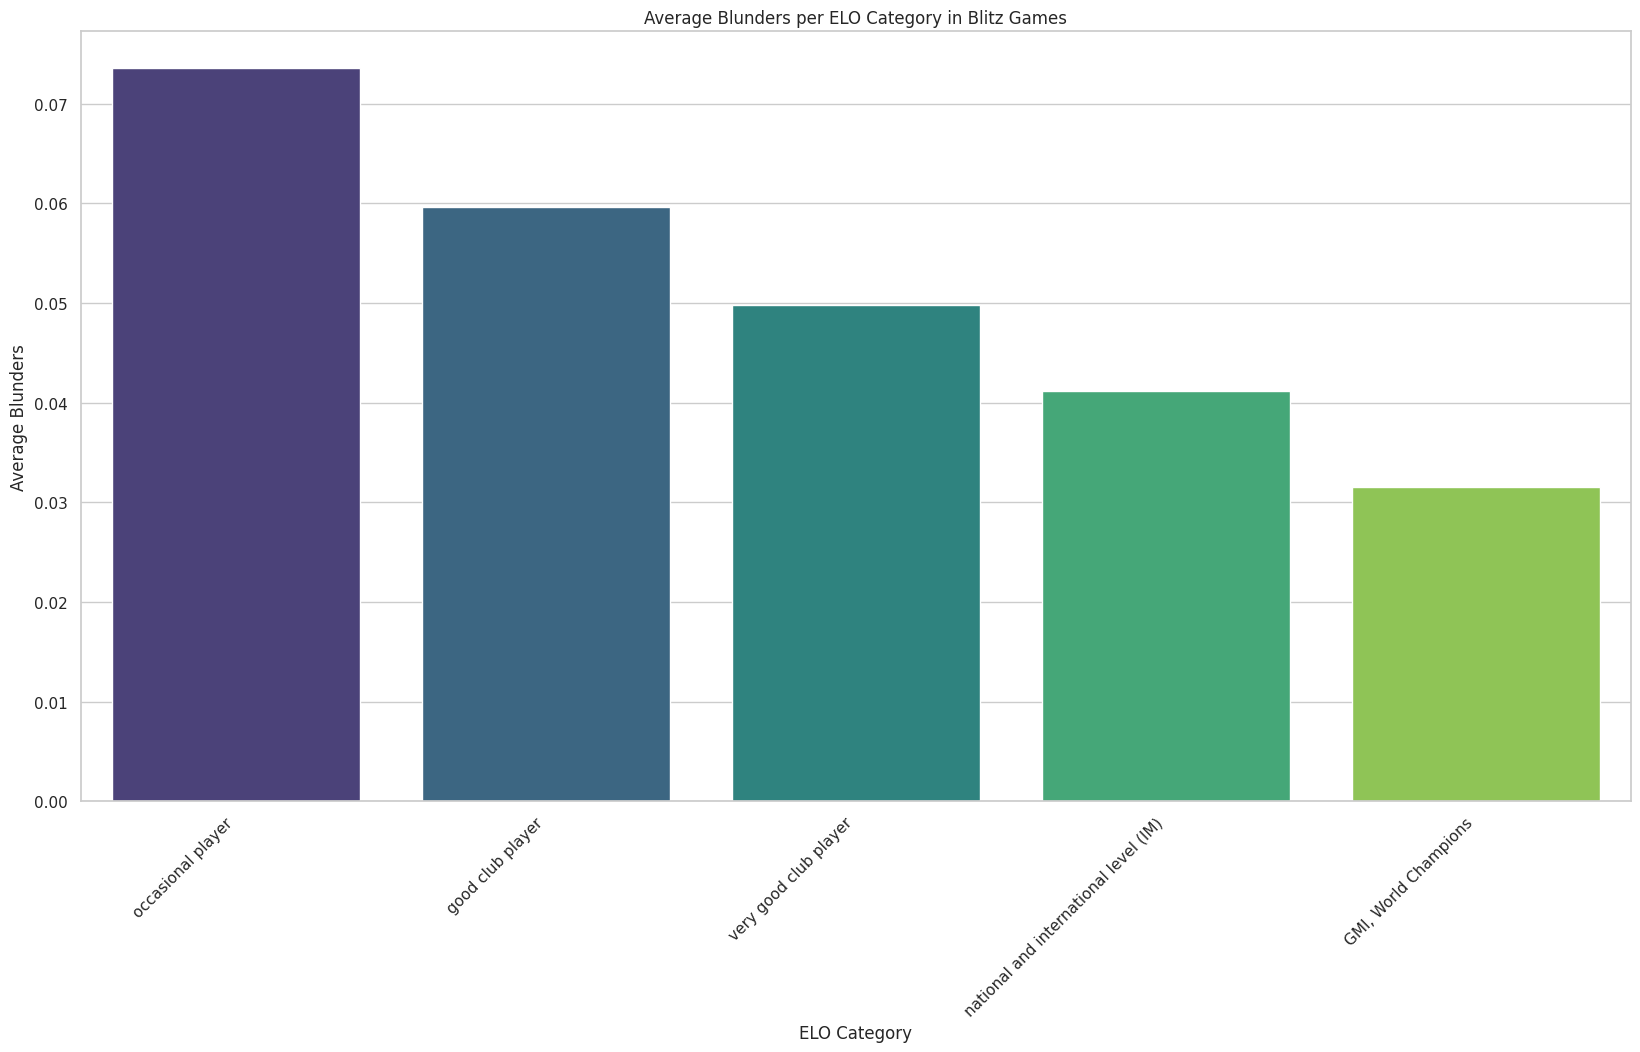

In [66]:
# Convert the dictionary to a DataFrame for easier plotting
data = pd.DataFrame(list(average_blunders_dict.items()), columns=['ELO Category', 'Average Blunders'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x='ELO Category', y='Average Blunders', data=data, palette="viridis")

# Set labels and title
plt.xlabel("ELO Category")
plt.ylabel("Average Blunders")
plt.title("Average Blunders per ELO Category in Blitz Games")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

The results are what we could expect even as a non chess player, the higher the elo, the lower the blunders rate 

In [67]:
# average mistakes per move by elo category
average_mistakes_dict: dict[str,int ] = {}

# iterate through elo categories

for elo_category in elo_categories:
    # calculate the average mistakes per move based on black mistakes + white mistakes and number of moves
    average_mistakes = (
        blitz_data.filter(F.col("Black_elo_category") == elo_category)
        .select(
            ((F.sum("Black_mistakes") + F.sum("White_mistakes")) / F.sum("Total_moves")).alias("avg_mistakes_per_move")
        )
        .agg(F.avg("avg_mistakes_per_move").alias("average_mistakes"))
        .collect()[0]["average_mistakes"]
    )
    # add the average mistakes to the dictionary
    average_mistakes_dict[elo_category] = average_mistakes

# order the dictionary by value by descending order
average_mistakes_dict = dict(sorted(average_mistakes_dict.items(), key=lambda item: item[1], reverse=True))

# print the dictionary
print(average_mistakes_dict)

{'occasional player': 0.10357127308249324, 'good club player': 0.09849008092019497, 'very good club player': 0.09185612856049091, 'national and international level (IM)': 0.08098591524550514, 'GMI, World Champions': 0.06489503789954766}


/tmp/ipykernel_81712/599266480.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ELO Category', y='Average Mistakes', data=data, palette="viridis")


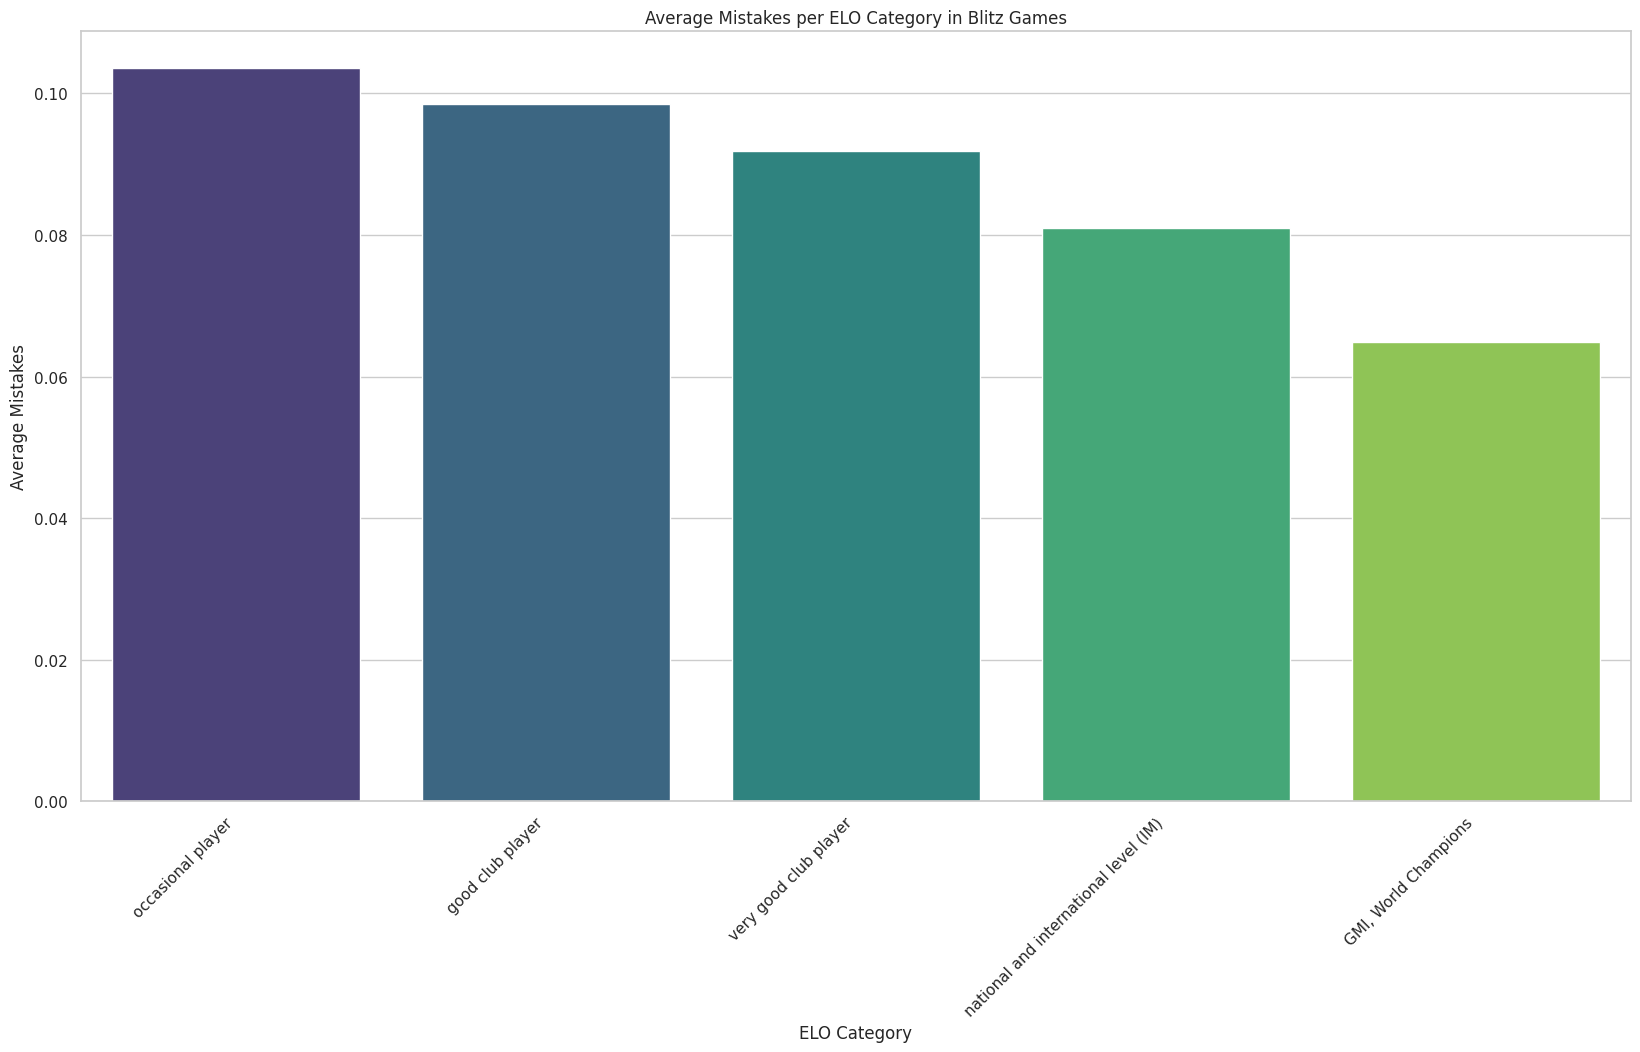

In [68]:
# convert the dictionary to a DataFrame for easier plotting
data = pd.DataFrame(list(average_mistakes_dict.items()), columns=['ELO Category', 'Average Mistakes'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x='ELO Category', y='Average Mistakes', data=data, palette="viridis")

# Set labels and title
plt.xlabel("ELO Category")
plt.ylabel("Average Mistakes")
plt.title("Average Mistakes per ELO Category in Blitz Games")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

also for mistakes the higher the elo the lower the mistakes rate but the difference looks less important than for blunders, well i guess grandmasters are also humans!!!

In [69]:
# average inaccuracies per move by elo category
average_inaccuracies_dict: dict[str,int ] = {}

# iterate through elo categories

for elo_category in elo_categories:
    # calculate the average inaccuracies per move based on black inaccuracies + white inaccuracies and number of moves
    average_inaccuracies = (
        blitz_data.filter(F.col("Black_elo_category") == elo_category)
        .select(
            ((F.sum("Black_inaccuracies") + F.sum("White_inaccuracies")) / F.sum("Total_moves")).alias("avg_inaccuracies_per_move")
        )
        .agg(F.avg("avg_inaccuracies_per_move").alias("average_inaccuracies"))
        .collect()[0]["average_inaccuracies"]
    )
    # add the average inaccuracies to the dictionary
    average_inaccuracies_dict[elo_category] = average_inaccuracies

# order the dictionary by value by descending order
average_inaccuracies_dict = dict(sorted(average_inaccuracies_dict.items(), key=lambda item: item[1], reverse=True))

# print the dictionary
print(average_inaccuracies_dict)

{'good club player': 0.09098977415627109, 'occasional player': 0.0901653740438934, 'very good club player': 0.08929071290770434, 'national and international level (IM)': 0.08317791090185256, 'GMI, World Champions': 0.07186211093619085}


/tmp/ipykernel_81712/98420545.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ELO Category', y='Average Inaccuracies', data=data, palette="viridis")


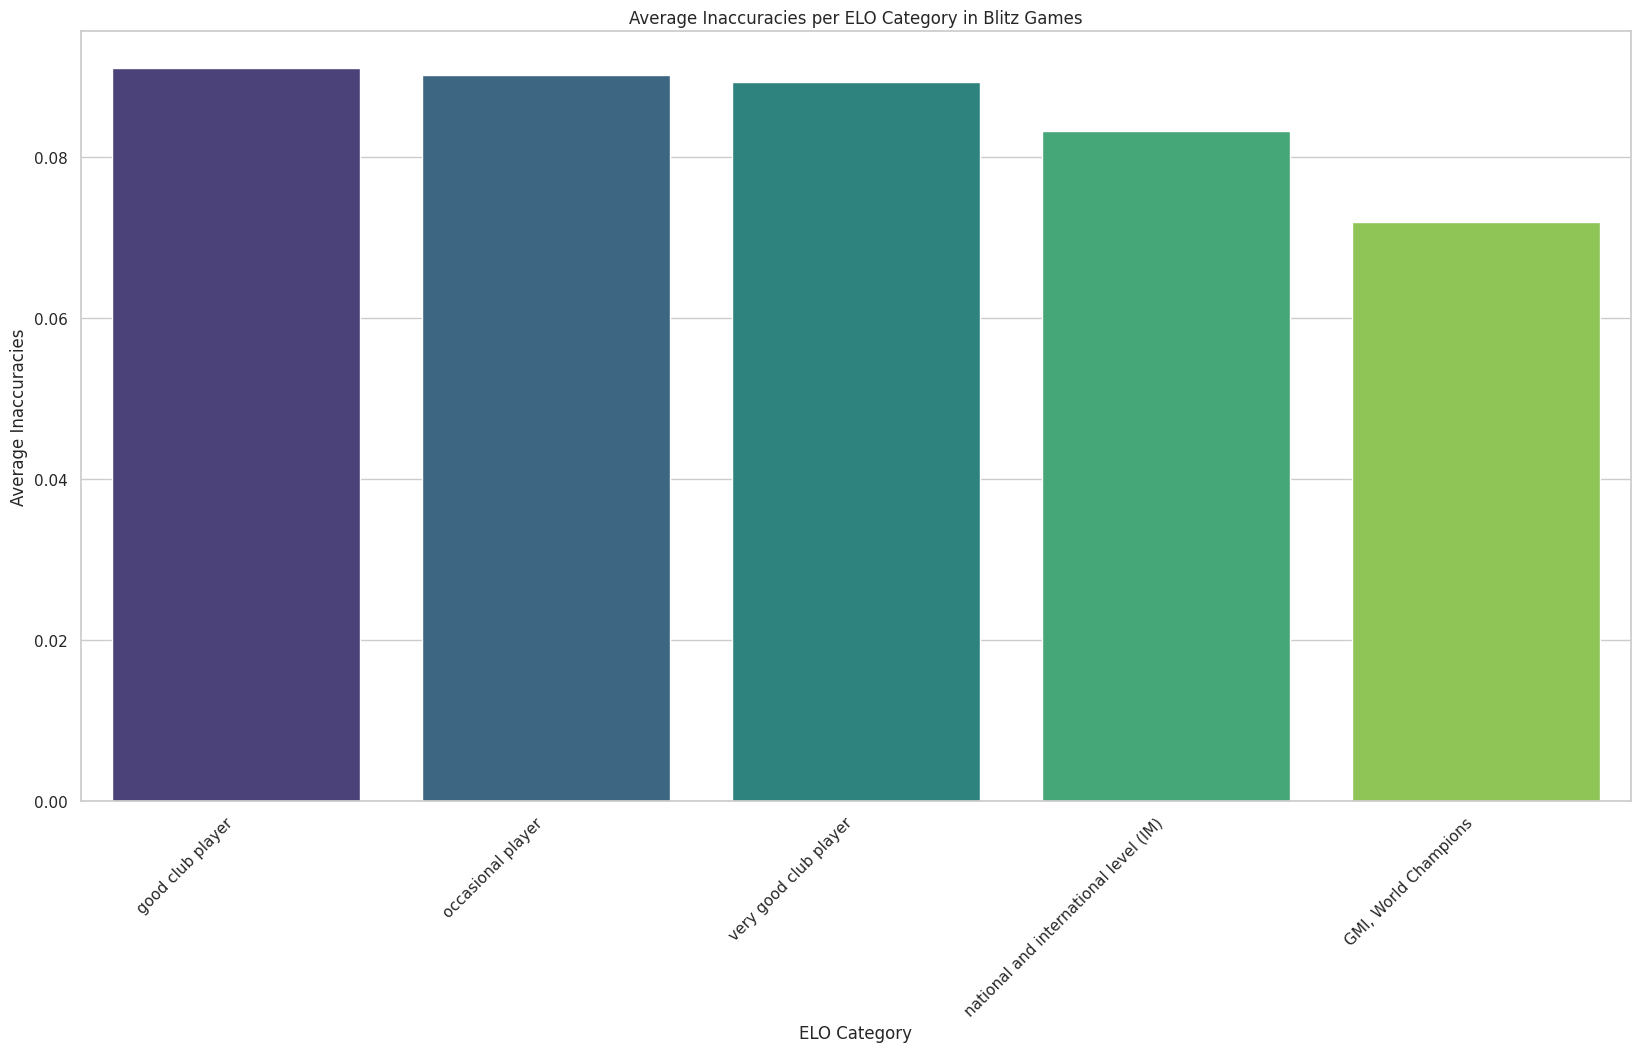

In [70]:
# convert the dictionary to a DataFrame for easier plotting
data = pd.DataFrame(list(average_inaccuracies_dict.items()), columns=['ELO Category', 'Average Inaccuracies'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x='ELO Category', y='Average Inaccuracies', data=data, palette="viridis")

# Set labels and title
plt.xlabel("ELO Category")
plt.ylabel("Average Inaccuracies")
plt.title("Average Inaccuracies per ELO Category in Blitz Games")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

Same remark for inaccuracies, the higher the elo the lower the inaccuracies rate but the difference looks less important than for blunders.

/tmp/ipykernel_81712/584615924.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


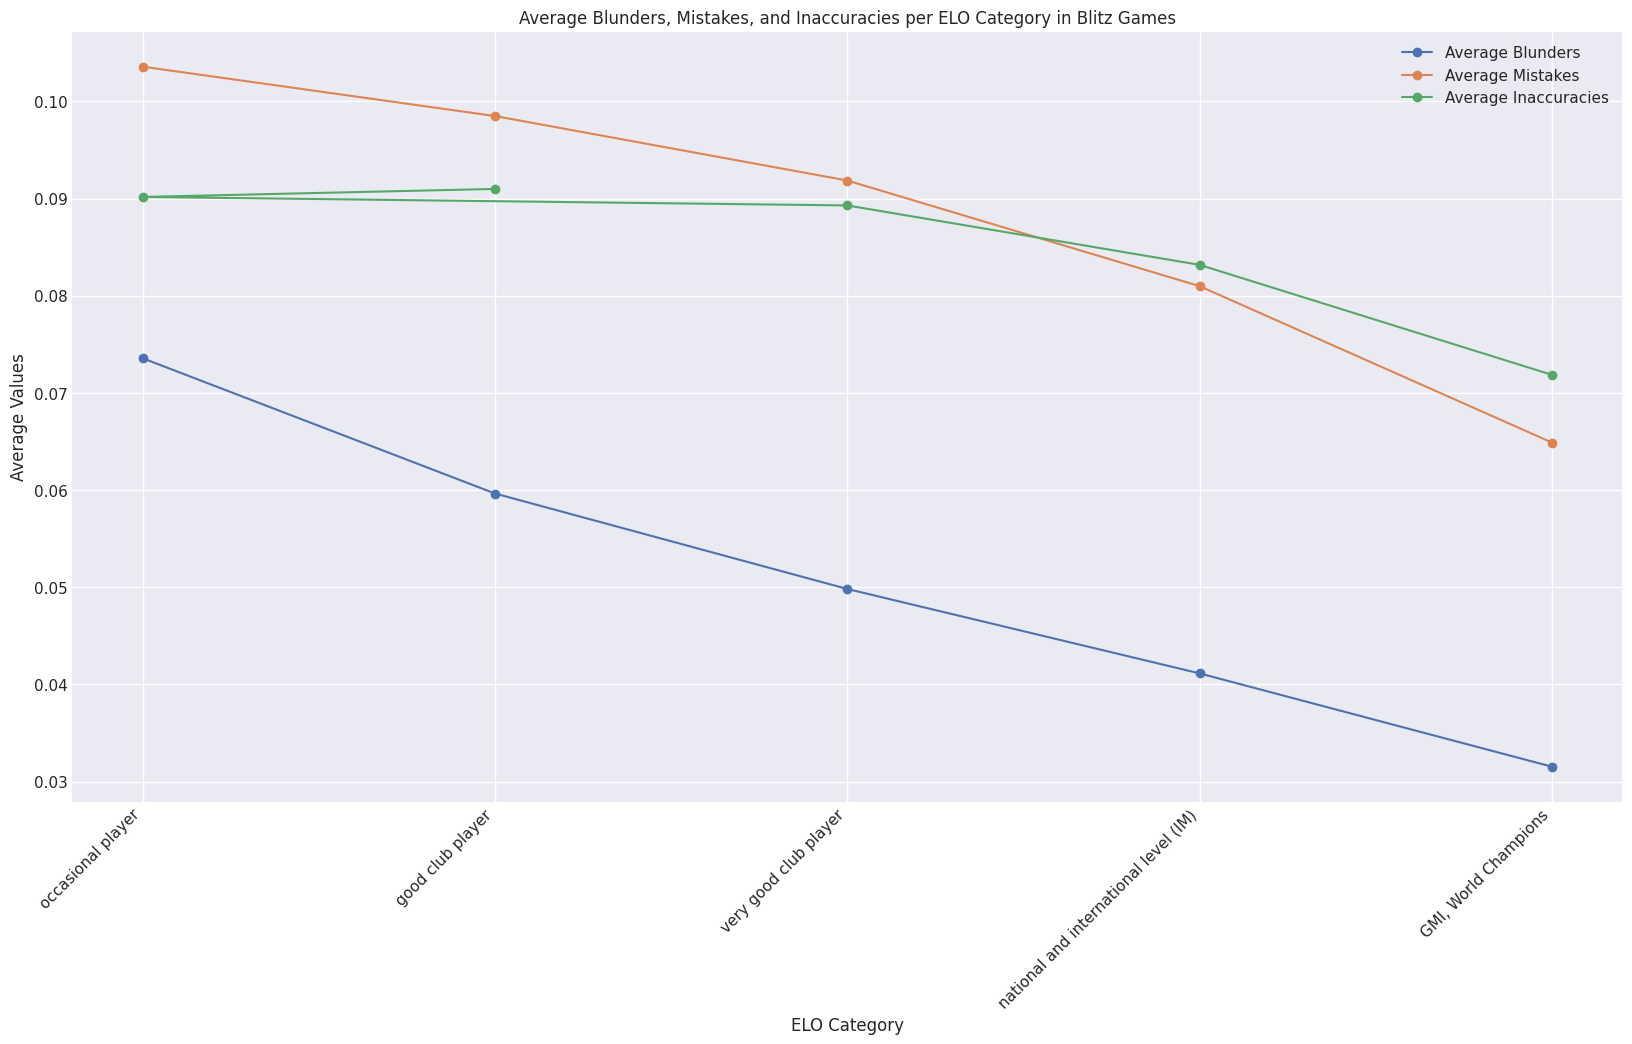

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming average_blunders_dict, average_mistakes_dict, and average_inaccuracies_dict are dictionaries with ELO categories as keys and average values as values

# Convert dictionaries to DataFrames for easier plotting
blunders_data = pd.DataFrame(list(average_blunders_dict.items()), columns=['ELO Category', 'Average Blunders'])
mistakes_data = pd.DataFrame(list(average_mistakes_dict.items()), columns=['ELO Category', 'Average Mistakes'])
inaccuracies_data = pd.DataFrame(list(average_inaccuracies_dict.items()), columns=['ELO Category', 'Average Inaccuracies'])

# Set the style for the plot
plt.style.use('seaborn-darkgrid')

# Plot average blunders
plt.figure(figsize=(20, 10))
plt.plot(blunders_data['ELO Category'], blunders_data['Average Blunders'], marker='o', label='Average Blunders')

# Plot average mistakes
plt.plot(mistakes_data['ELO Category'], mistakes_data['Average Mistakes'], marker='o', label='Average Mistakes')

# Plot average inaccuracies
plt.plot(inaccuracies_data['ELO Category'], inaccuracies_data['Average Inaccuracies'], marker='o', label='Average Inaccuracies')

# Set labels and title
plt.xlabel("ELO Category")
plt.ylabel("Average Values")
plt.title("Average Blunders, Mistakes, and Inaccuracies per ELO Category in Blitz Games")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Display a legend
plt.legend()

# Show the plot
plt.show()

Open question : can we deduce a relation between the elo and the rate of blunders, errors and inaccuracies per move ( aka inferior moves rate )  per elo category in blitz games?

In [72]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Select relevant columns for the analysis
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Select relevant columns for the analysis
elo_columns = ["BlackElo", "Black_elo_category", "Black_inferior_moves"]
elo_data = blitz_data.select(*elo_columns)

# Handle categorical columns
elo_data = elo_data.withColumn("Black_elo_category", 
                               when(col("Black_elo_category") == "occasional player", 1)
                               .when(col("Black_elo_category") == "good club player", 2)
                               .when(col("Black_elo_category") == "very good club player", 3)
                               .when(col("Black_elo_category") == "national and international level (IM)", 4)
                               .when(col("Black_elo_category") == "GMI, World Champions", 5)
                               .otherwise(0)
                              )

# Create a list to store regression models
regression_models = []

# Iterate over ELO categories
for category in range(1, 6):
    # Filter data for the current category
    category_data = elo_data.filter(elo_data["Black_elo_category"] == category)
    
    # Create a feature vector
    assembler = VectorAssembler(inputCols=["BlackElo"], outputCol="features")
    category_data = assembler.transform(category_data)
    
    # Train a linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="Black_inferior_moves", maxIter=10)
    pipeline = Pipeline(stages=[lr])
    model = pipeline.fit(category_data)
    
    # Save the model in the list
    regression_models.append((category, model))

# Display coefficients and intercepts for each category
for category, model in regression_models:
    coefficients = model.stages[-1].coefficients
    intercept = model.stages[-1].intercept
    print(f"Category {category}: Coefficients - {coefficients}, Intercept - {intercept}")



24/01/12 21:34:16 WARN Instrumentation: [25f86535] regParam is zero, which might cause numerical instability and overfitting.
24/01/12 21:34:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/12 21:34:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/01/12 21:34:23 WARN Instrumentation: [855ce4c7] regParam is zero, which might cause numerical instability and overfitting.
24/01/12 21:34:29 WARN Instrumentation: [b85d5960] regParam is zero, which might cause numerical instability and overfitting.
24/01/12 21:34:35 WARN Instrumentation: [35dde2cf] regParam is zero, which might cause numerical instability and overfitting.
24/01/12 21:34:40 WARN Instrumentation: [47cfa255] regParam is zero, which might cause numerical instability and overfitting.


Category 1: Coefficients - [-0.0002928172171634402], Intercept - 8.70677380357061
Category 2: Coefficients - [-0.0006881396300389643], Intercept - 9.2953972553968
Category 3: Coefficients - [-0.0015972006814997898], Intercept - 11.020840515784815
Category 4: Coefficients - [-0.0021108087982710222], Intercept - 12.190959977586454
Category 5: Coefficients - [-0.0021720670050062642], Intercept - 12.661102215740518


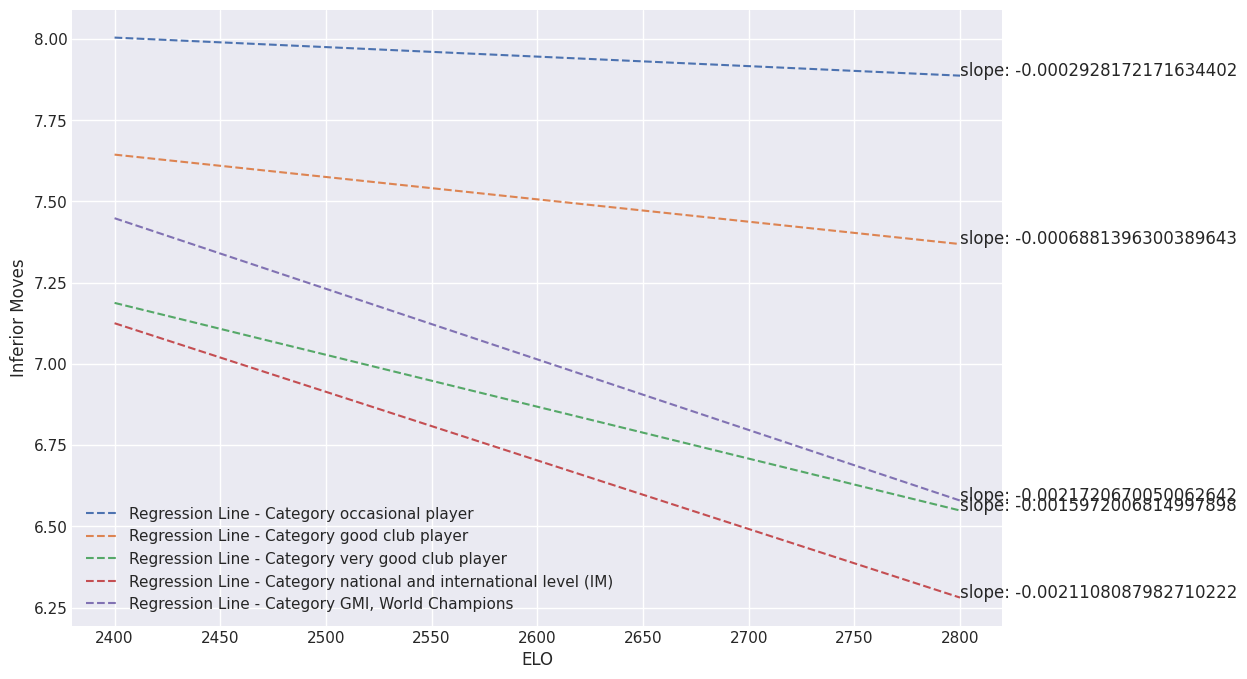

In [73]:
# Plot the regression lines only
plt.figure(figsize=(12, 8))

# dict of categories 
categories = {
    1: "occasional player",
    2: "good club player",
    3: "very good club player",
    4: "national and international level (IM)",
    5: "GMI, World Champions"
}

for category, model in regression_models:
    # Extract coefficients and intercept
    coefficients = model.stages[-1].coefficients
    intercept = model.stages[-1].intercept
    
    # Plot regression line
    x_values = np.linspace(min(category_data.select("BlackElo").rdd.flatMap(lambda x: x).collect()),
                           max(category_data.select("BlackElo").rdd.flatMap(lambda x: x).collect()), 100)
    y_values = coefficients[0] * x_values + intercept
    plt.plot(x_values, y_values, label=f"Regression Line - Category {categories[category]}", linestyle='--')
    # print the slope at the end of the line
    plt.text(x_values[-1], y_values[-1], f"slope: {coefficients[0]}")

plt.xlabel("ELO")
plt.ylabel("Inferior Moves")
plt.legend()
plt.show()

as expected the higher the elo the lower the inferior moves rate justified by the slope of the linear regression for each elo category. thus we can predict the inferior moves rate for a given elo category in blitz games with a linear regression model. ( not reliable because of high variance )

## Q2 Win probability depending on opening

before answering this question let's see the most played openings elo category and game type combined

First we notice that there is a lot openings than eco code that is mainly to sub variation of openings that are not necessarily assigned distinct ECO codes.
also many sub variations are played very few times so we will only consider only the openings withou sub variations.

In [81]:
from pyspark.sql.functions import udf

# function to get the opening name without the variation
def get_opening(opening):
    return opening.split(":")[0].split(",")[0]


# add a new column with the cleaned opening
get_opening_udf = udf(get_opening, StringType())
df = df.withColumn("Opening_without_var", get_opening_udf(df.Opening))

Openings_without_var = df.select("Opening_without_var").distinct().rdd.flatMap(lambda x: x).collect()
openings = df.select("Opening").distinct().rdd.flatMap(lambda x: x).collect()


# number of different openings before and after cleaning
print("There are {} different openings before cleaning".format(len(openings)), "and {} different openings after cleaning".format(len(Openings_without_var)))


There are 2779 different openings before cleaning and 170 different openings after cleaning


First let's see what are the most played openings by elo category and game type 

In [82]:
# number of openings per game type and elo category
df.groupBy("Game_type", "White_elo_category", "Opening_without_var").count().orderBy(desc("count")).show(10)

+---------+--------------------+-------------------+-----+
|Game_type|  White_elo_category|Opening_without_var|count|
+---------+--------------------+-------------------+-----+
|    Blitz|    good club player|   Sicilian Defense|82693|
|    Blitz|very good club pl...|   Sicilian Defense|51970|
|    Rapid|    good club player|   Sicilian Defense|50424|
|    Blitz|   occasional player|   Sicilian Defense|48931|
|    Blitz|national and inte...|   Sicilian Defense|46391|
|    Blitz|    good club player|  Queen's Pawn Game|36439|
|    Blitz|    good club player|     French Defense|34597|
|    Blitz|   occasional player|  Queen's Pawn Game|33212|
|    Rapid|very good club pl...|   Sicilian Defense|29777|
|   Bullet|    good club player|   Sicilian Defense|28560|
+---------+--------------------+-------------------+-----+
only showing top 10 rows



Secondly let's not consider the elo of the players nor the elo category and let's see the win probability depending on opening for white and black players.

In [83]:
df.show(10)

+----+--------+---------------+---+--------------------+--------------------+------+------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+--------------------+
|GAME|BlackElo|BlackRatingDiff|ECO|               Event|             Opening|Result| Termination|WhiteElo|WhiteRatingDiff|  Black_elo_category|  White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_m

In [84]:
threshold = 80_000

# calculate win rates for each opening and color
opening_win_rates = (
    df.groupBy("Opening_without_var", "Result")
    .count()
    .groupBy("Opening_without_var")
    .agg(
        F.sum("count").alias("total_games"),
        F.sum(F.when(F.col("Result") == "1-0", F.col("count")).otherwise(0)).alias("white_wins"),
        F.sum(F.when(F.col("Result") == "0-1", F.col("count")).otherwise(0)).alias("black_wins"),
        F.sum(F.when(F.col("Result") == "1/2-1/2", F.col("count")).otherwise(0)).alias("draws"),
    )
    .filter(F.col("total_games") > threshold)
    .withColumn("white_win_rate", F.col("white_wins") / F.col("total_games"))
    .withColumn("black_win_rate", F.col("black_wins") / F.col("total_games"))
    .withColumn("draw_rate", F.col("draws") / F.col("total_games"))
    .select("Opening_without_var", "white_win_rate", "black_win_rate", "draw_rate")
    .fillna(0)  # replace NaN with 0 for cases where there are no wins
    .toPandas()  
)


# Convert Pandas DataFrame to dictionary
opening_win_rates_dict = {
    row["Opening_without_var"]: {"white": row["white_win_rate"], "black": row["black_win_rate"], "draw": row["draw_rate"]}
    for _, row in opening_win_rates.iterrows()
}

# Print the dictionary in a readable format
for opening, win_rates in opening_win_rates_dict.items():
    print(opening, win_rates)

# extract the best openings for white
best_openings_white = {opening: win_rates["white"] for opening, win_rates in opening_win_rates_dict.items()}

# sort the dictionary by value by descending order
best_openings_white = dict(sorted(best_openings_white.items(), key=lambda item: item[1], reverse=True))

# print the dictionary
print("Best openings for white:")
print(best_openings_white)

# extract the best openings for black
best_openings_black = {opening: win_rates["black"] for opening, win_rates in opening_win_rates_dict.items()}
# sort the dictionary by value by descending order
best_openings_black = dict(sorted(best_openings_black.items(), key=lambda item: item[1], reverse=True))

# print the dictionary
print("Best openings for black:")
print(best_openings_black)


Caro-Kann Defense {'white': 0.45695226349971574, 'black': 0.5050731543247939, 'draw': 0.037934541494158064}
Sicilian Defense {'white': 0.4653820284709847, 'black': 0.501006584984202, 'draw': 0.033581339231852}
Italian Game {'white': 0.513855834481539, 'black': 0.4571651721571777, 'draw': 0.028964257031071552}
Ruy Lopez {'white': 0.5366325715378816, 'black': 0.42759567453217656, 'draw': 0.035760501412190976}
English Opening {'white': 0.5234617239716116, 'black': 0.4401312616275064, 'draw': 0.036389788465513676}
Queen's Pawn Game {'white': 0.5011856995627421, 'black': 0.46624008164817243, 'draw': 0.03255920993386098}
Scandinavian Defense {'white': 0.5162067930068064, 'black': 0.45565027358868276, 'draw': 0.02810956893100227}
French Defense {'white': 0.48394059194358374, 'black': 0.48367346938775513, 'draw': 0.032353883961961746}
Best openings for white:
{'Ruy Lopez': 0.5366325715378816, 'English Opening': 0.5234617239716116, 'Scandinavian Defense': 0.5162067930068064, 'Italian Game': 0.5

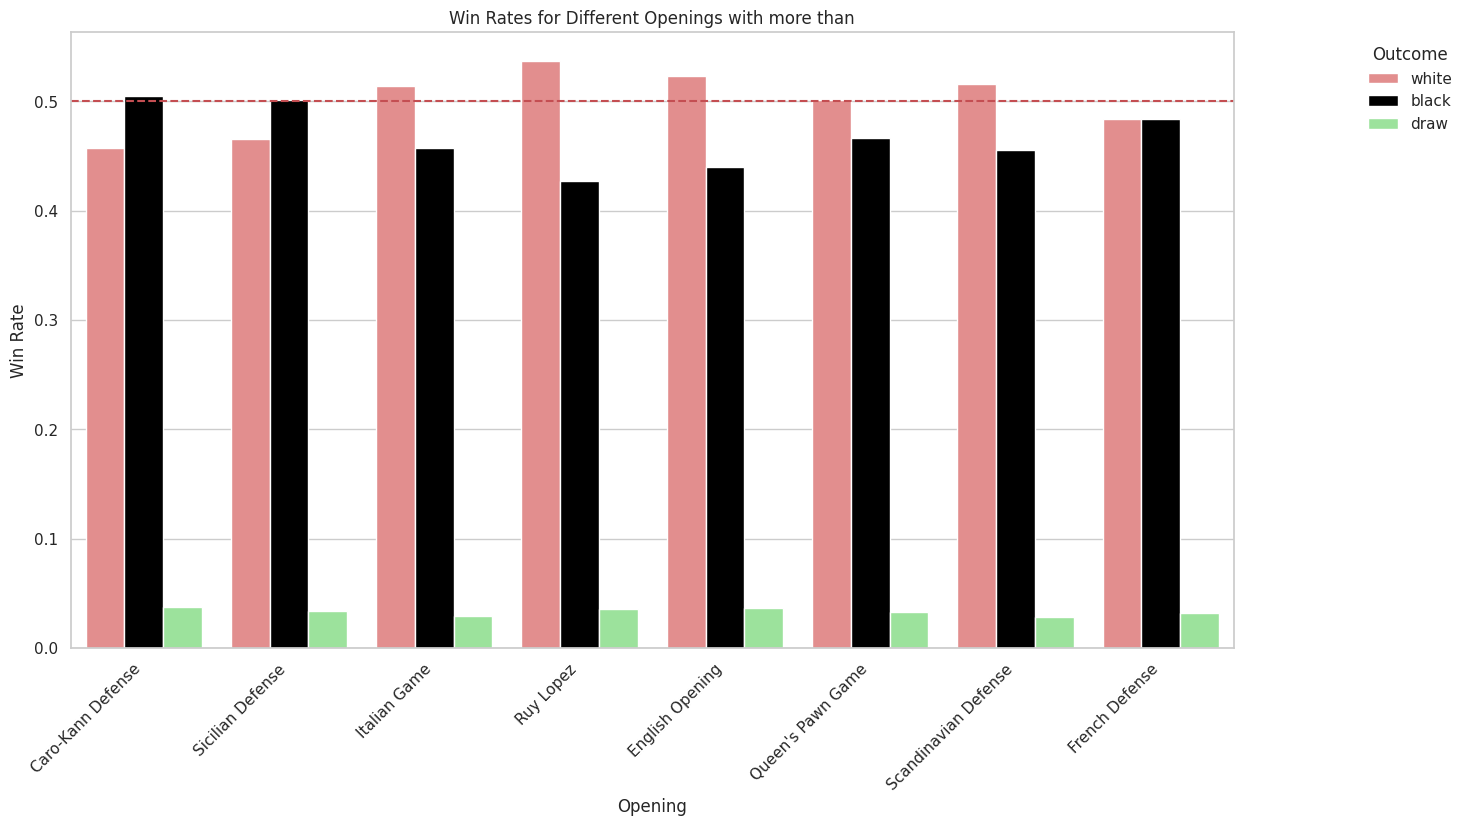

In [85]:
# Convert dictionary to a Pandas DataFrame
opening_win_rates_df = pd.DataFrame.from_dict(opening_win_rates_dict, orient='index')
opening_win_rates_df.reset_index(inplace=True)
opening_win_rates_df.rename(columns={'index': 'Opening'}, inplace=True)

# Set Seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame for better plotting with Seaborn
melted_df = pd.melt(opening_win_rates_df, id_vars=['Opening'], var_name='Color', value_name='Win Rate')

# Plot grouped bar chart using Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='Opening', y='Win Rate', hue='Color', data=melted_df, palette={'white': 'lightcoral', 'black': 'black', 'draw': 'lightgreen'})
# add a horizontal hachuré line at 50% win rate
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation=45, ha="right")
plt.title("Win Rates for Different Openings with more than")
plt.xlabel("Opening")
plt.ylabel("Win Rate")
plt.legend(title="Outcome", loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()


White goes first, giving them an advantage that Black tries to balance out. But the results can be hard to predict and are rarely determined by the opening.

we did consider only the openings with more than 10000 occurrences for better representation ,but with this approach we cannot draw any conclusion, except that Philidor Defense gives better chances to white players and the Van't Kruijs Opening gives better chances to black players accross all elo categories and all types of games.


Now let's go back to our original question, what is the win probability depending on opening white and black player by elo category and by type of game : blitz, bullet or rapid ( we will consider classical as there is not enough data for correspondence games)

### now let's consider the elo of the players and game type and see the win probability depending on opening for white and black players

In [86]:
df.show(10)
# number of lines in the dataset
print("There are {} lines in the dataset".format(df.count()))

+----+--------+---------------+---+--------------------+--------------------+------+------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+--------------------+
|GAME|BlackElo|BlackRatingDiff|ECO|               Event|             Opening|Result| Termination|WhiteElo|WhiteRatingDiff|  Black_elo_category|  White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_m

There are 3029337 lines in the dataset


In [87]:
from pyspark.sql import functions as F

threshold = 2000

# Calculate win probability for White by Opening_without_var, ELO category, and game type
white_win_df = df.filter(df["Result"] == "1-0").groupBy("Opening_without_var", "White_elo_category", "Game_type").count().withColumnRenamed("count", "white_win_count")

# Calculate total games for each Opening_without_var, ELO category, and game type
total_games_df = df.groupBy("Opening_without_var", "White_elo_category", "Game_type").count().withColumnRenamed("count", "total_games_count")

# Merge the results
merged_df = white_win_df.join(total_games_df, ["Opening_without_var", "White_elo_category", "Game_type"], "outer").na.fill(0)

# Calculate win probabilities
merged_df = merged_df.withColumn("white_win_prob", F.col("white_win_count") / F.col("total_games_count"))

# filter on just the openings that have more than threshold games
merged_df = merged_df.filter(merged_df["total_games_count"] >= threshold)

# order by win probability in descending order
merged_df = merged_df.orderBy("white_win_prob", ascending=False)

# show the first 10 rows
merged_df.show(1000)


+--------------------+--------------------+---------+---------------+-----------------+-------------------+
| Opening_without_var|  White_elo_category|Game_type|white_win_count|total_games_count|     white_win_prob|
+--------------------+--------------------+---------+---------------+-----------------+-------------------+
|    Philidor Defense|very good club pl...|    Rapid|           2413|             3807| 0.6338324139742579|
|Queen's Gambit Ac...|    good club player|    Rapid|           3378|             5395| 0.6261353104726599|
|Queen's Gambit Ac...|   occasional player|    Rapid|           2443|             3941| 0.6198934280639432|
|    Philidor Defense|    good club player|    Rapid|           6840|            11046|  0.619228680065182|
|Queen's Gambit Ac...|    good club player|    Blitz|           4052|             6546| 0.6190039718912312|
|    Philidor Defense|national and inte...|    Blitz|           1441|             2352| 0.6126700680272109|
|    Philidor Defense|very g

let's plot per game type and elo category

Let's see the win rate for white per elo category and game type

/tmp/ipykernel_81712/3663130195.py:28: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")


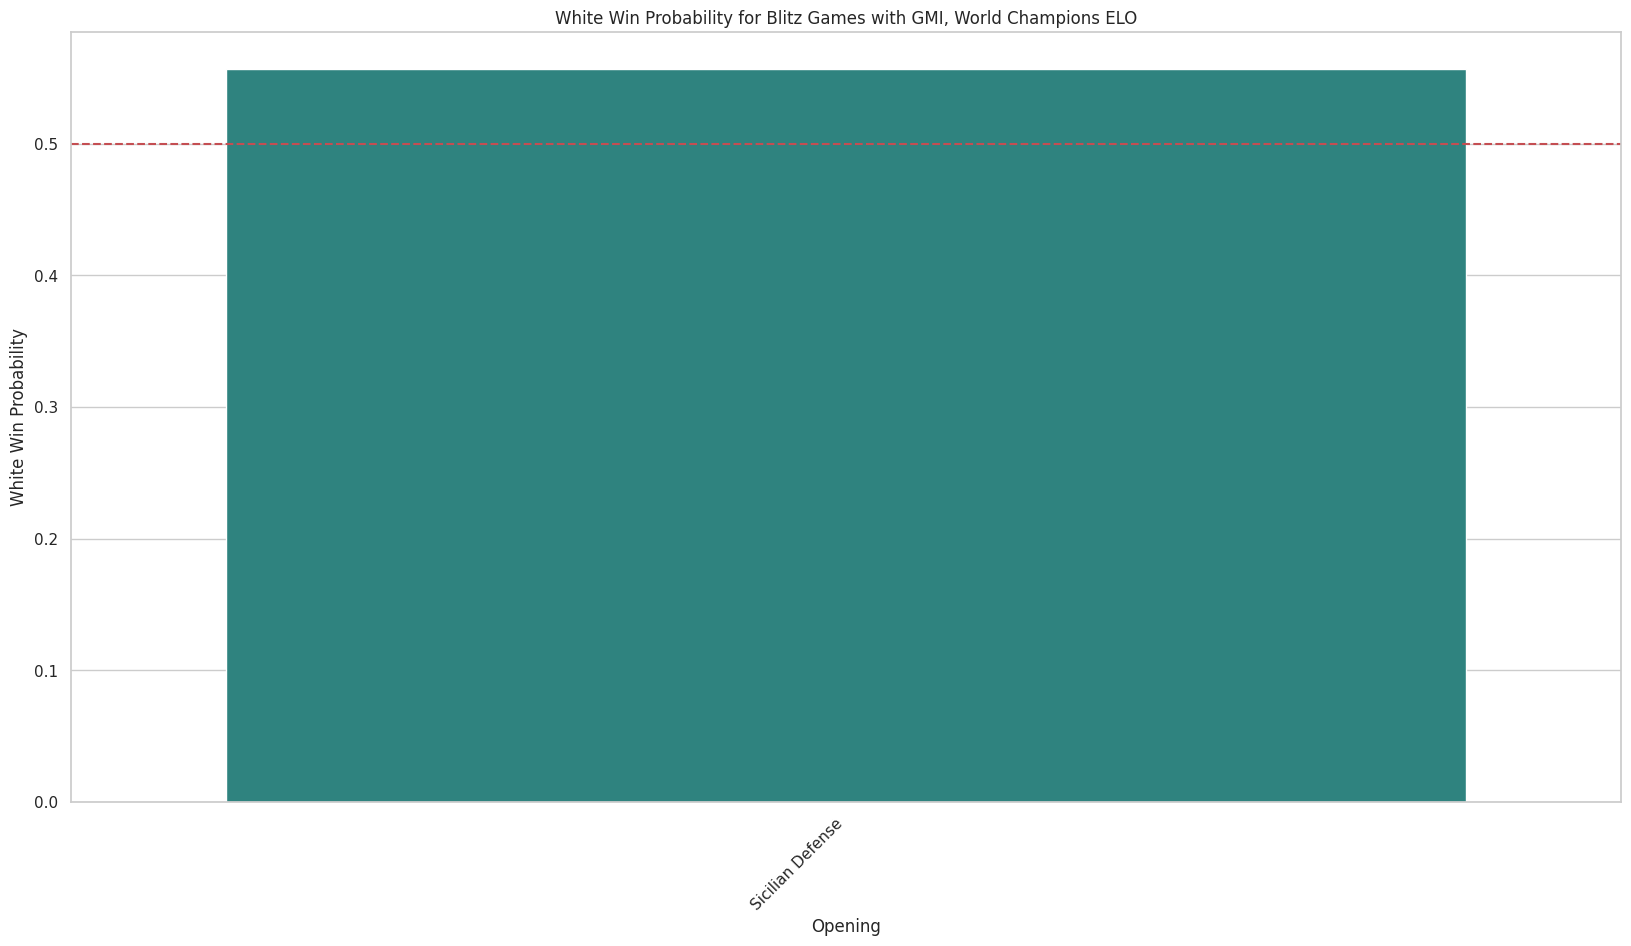

/tmp/ipykernel_81712/3663130195.py:28: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")


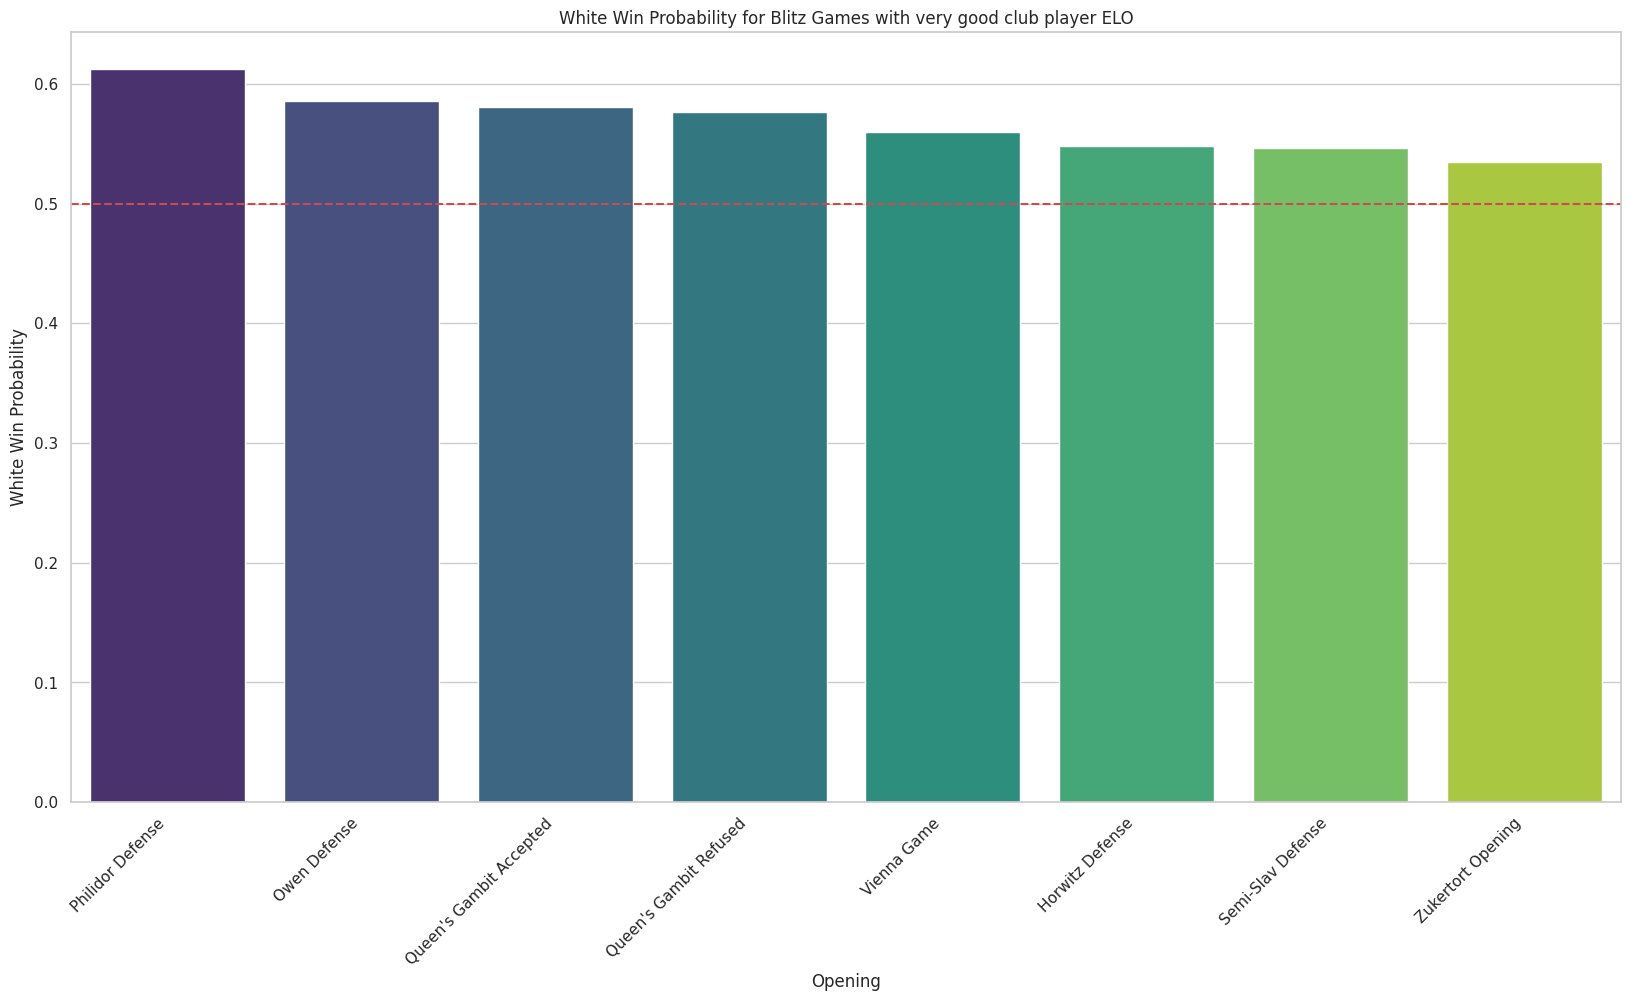

/tmp/ipykernel_81712/3663130195.py:28: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")


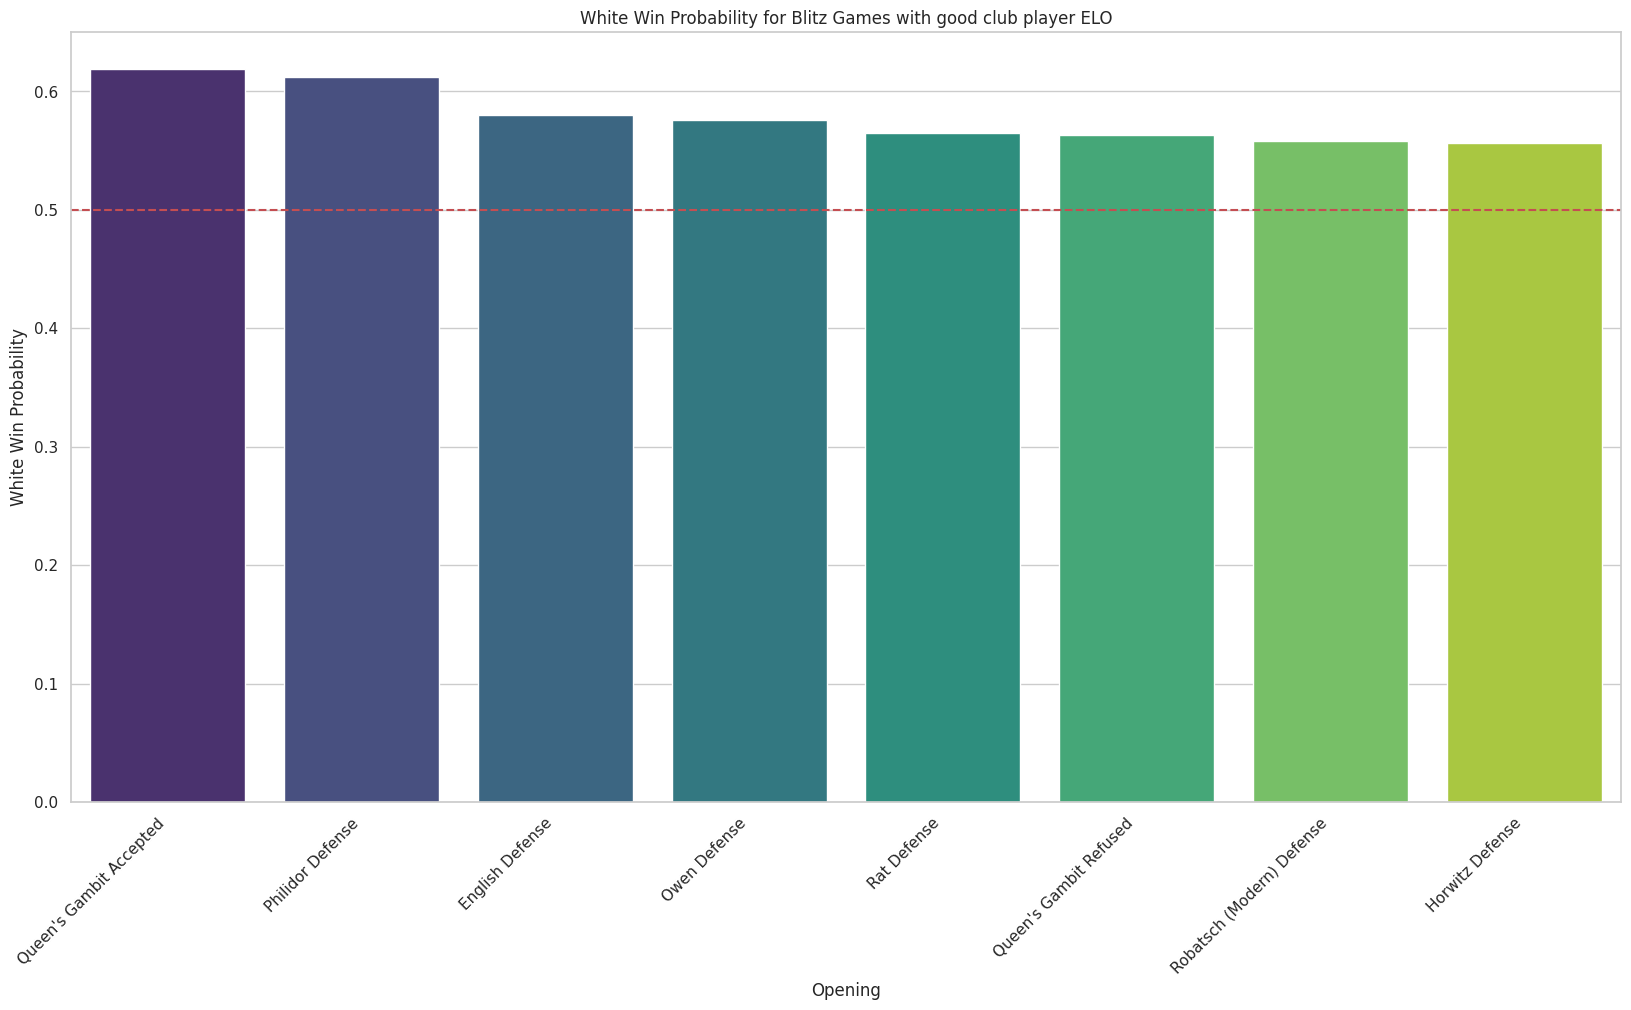

/tmp/ipykernel_81712/3663130195.py:28: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")


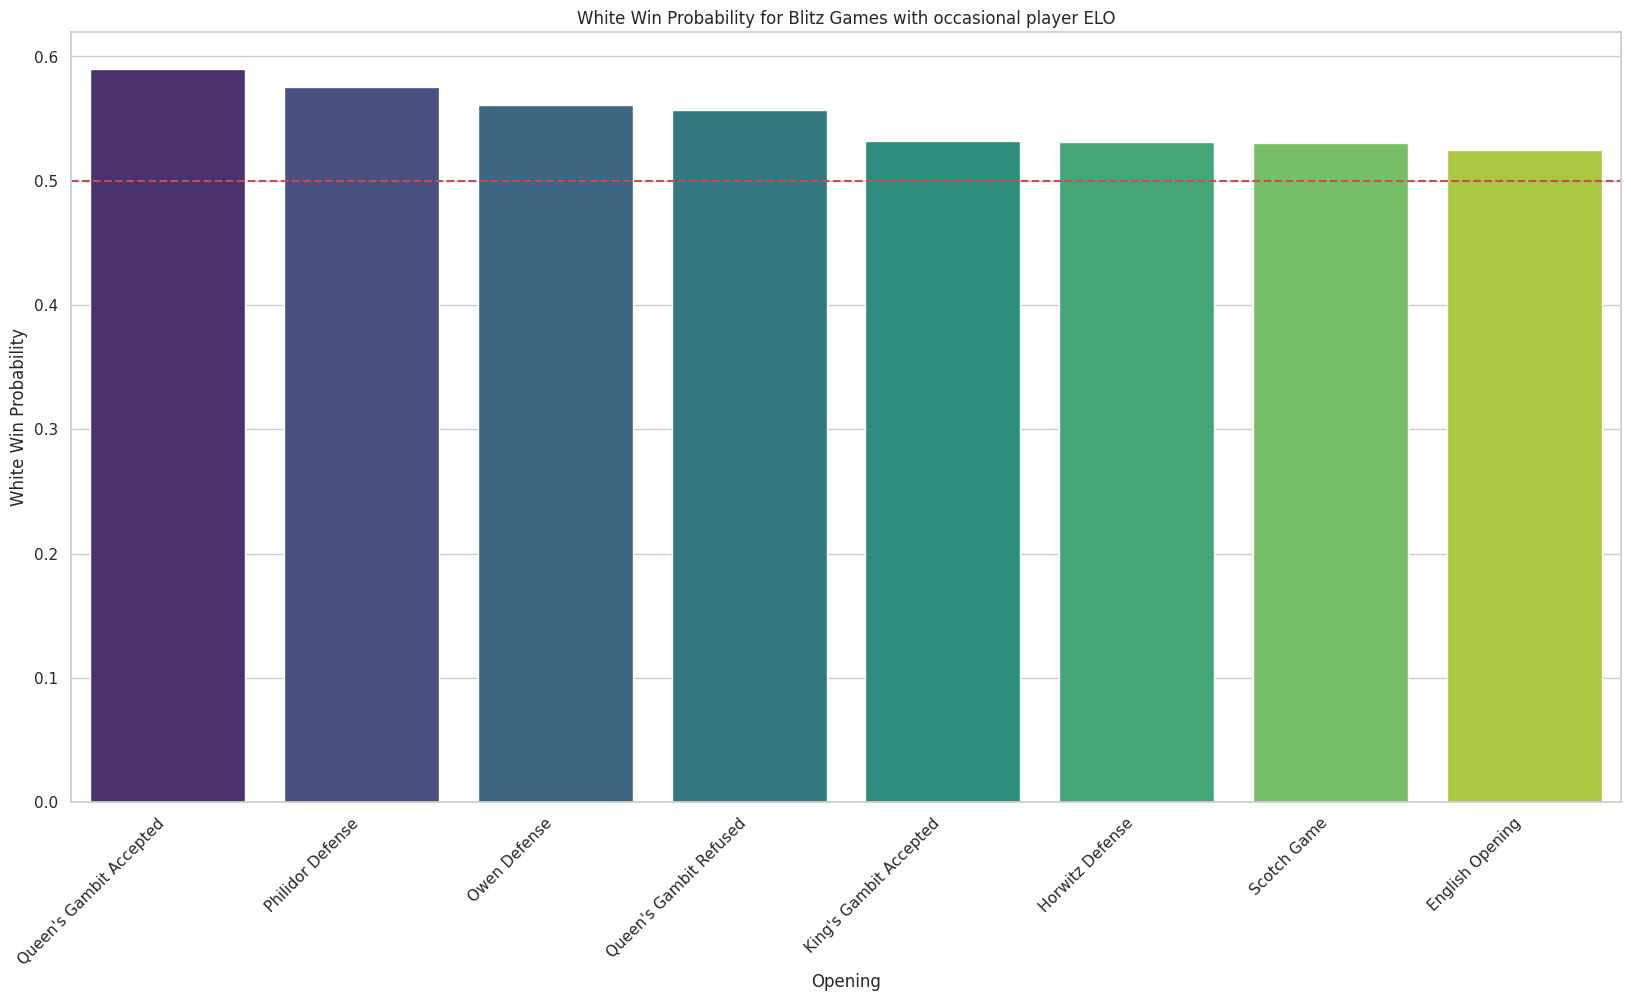

/tmp/ipykernel_81712/3663130195.py:28: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")


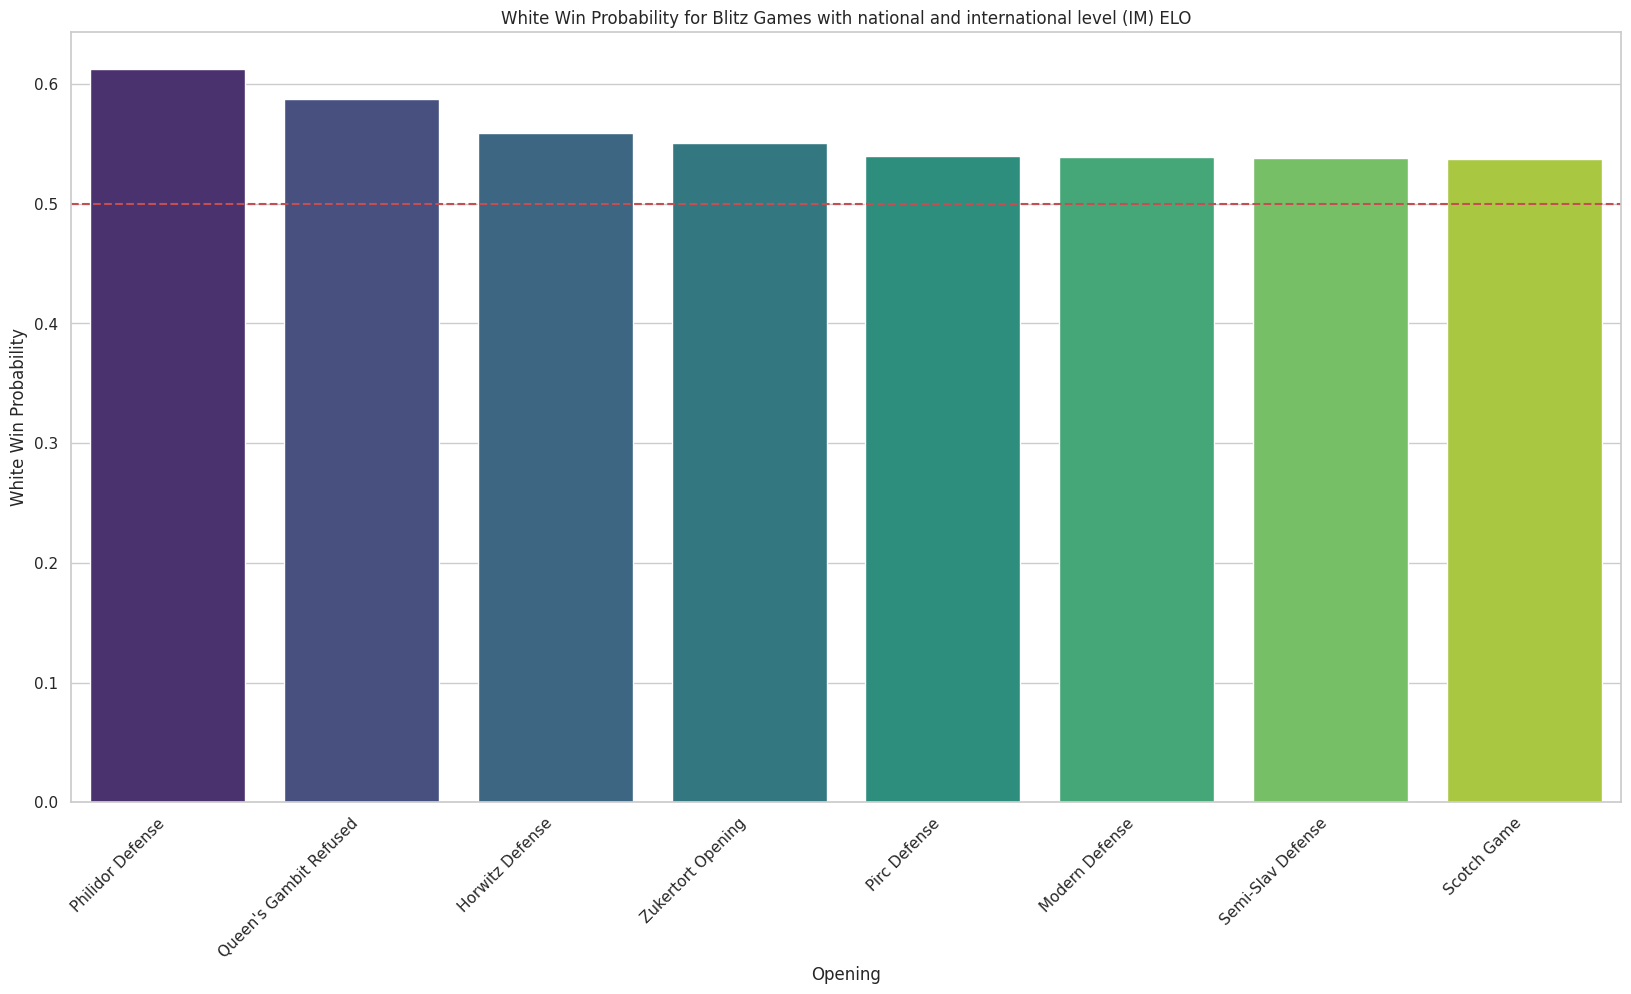

In [88]:
choice = input("Enter the game type (1 for Blitz, 2 for Rapid, 3 for Bullet): ")

if choice == "1":
    game_type = "Blitz"
elif choice == "2":
    game_type = "Rapid"
elif choice == "3":
    game_type = "Bullet"
else:
    print("Invalid choice")
    exit()

for elo_category in elo_categories:
    # filter the data for the specific game type and elo category
    filtered_df = merged_df.filter((merged_df["Game_type"] == game_type) & (merged_df["White_elo_category"] == elo_category))
    # convert the filtered data to a Pandas DataFrame
    filtered_df = filtered_df.toPandas()
    # if there are more than 8 openings, only keep the top 8
    if filtered_df.shape[0] > 8:
        filtered_df = filtered_df.head(8)
    if filtered_df.shape[0] == 0:
        print("There are no Rapid games with {} ELO with more than {}".format(elo_category, threshold))
        continue
    # set the style for the plot
    sns.set(style="whitegrid")
    # create a bar plot using Seaborn
    plt.figure(figsize=(20, 10))
    sns.barplot(x='Opening_without_var', y='white_win_prob', data=filtered_df, palette="viridis")
    # add a horizontal hachuré line at 50% win rate
    plt.axhline(y=0.5, color='r', linestyle='--')
    # set labels and title
    plt.xlabel("Opening")
    plt.ylabel("White Win Probability")
    plt.title("White Win Probability for {} Games with {} ELO".format(game_type, elo_category))
    # rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    # show the plot
    plt.show()

considering only the openings that are played more than 2000 times we have ->
For white players the highest win rate openings by elo category in blitz games are : 
- GMI : Sicilian Defense
- MI : Philidor Defense, Queen's Gambit Refused, Horwitz Defense
- Very good club player : Philidor Defense, Owen Defense, Queen's Gambit Accepted 
- Good club player : Queen's Gambit Accepted, Philidor Defense, English Defense
- occasional player : Queen's Gambit Accepted, Philidor Defense, Owen Defense

for Rapid games we have :
- GMI : Not enough data for reliable results
- MI : Ruy Lopez, Italian Game, Scandinavian Defense
- Very good club player : Philidor Defense, Ruy Lopez, Scotch Game
- Good club player : Queen's Gambit Accepted, Philidor Defense, Owen Defense
- occasional player : Queen's Gambit Accepted, Philidor Defense, Horwitz Defense

for Bullet games we have :
- GMI : not enough data for reliable results
- MI : Ruy Lopez, Italian Game, Scandinavian Defense
- Very good club player : Pirc Defense, Modern Defense, Zukertort Opening
- Good club player : Owen Defense, Queen's Gambit Accepted, Philidor Defense
- occasional player : Queen's Gambit Accepted, Queen's Gambit Refused, Ruy Lopez

Opening choices in chess reveal distinct strategic tendencies across ELO categories. Grandmasters favor the Sicilian Defense in Blitz, while International Masters show diversity. Very Good Club Players lean towards the Philidor Defense and Owen Defense, and Good Club Players prefer Queen's Gambit Accepted. Occasional Players often opt for Queen's Gambit Accepted. Limited data for Grandmasters in Rapid games warrants caution, but strategic choices like Ruy Lopez emerge for International Masters. In Bullet games, diversity reigns with preferences like Pirc Defense and Ruy Lopez. 

## Now let's the black player

In [89]:
# Calculate win probability for black by Opening_without_var, ELO category, and game type
black_win_df = df.filter(df["Result"] == "0-1").groupBy("Opening_without_var", "Black_elo_category", "Game_type").count().withColumnRenamed("count", "black_win_count")

# Calculate total games for each Opening_without_var, ELO category, and game type
total_games_df = df.groupBy("Opening_without_var", "Black_elo_category", "Game_type").count().withColumnRenamed("count", "total_games_count")

# Merge the results
merged_df = black_win_df.join(total_games_df, ["Opening_without_var", "Black_elo_category", "Game_type"], "outer").na.fill(0)

# Calculate win probabilities
merged_df = merged_df.withColumn("black_win_prob", F.col("black_win_count") / F.col("total_games_count"))

# filter on just the openings that have more than 10000 games
merged_df = merged_df.filter(merged_df["total_games_count"] >= threshold)

# order by win probability in descending order
merged_df = merged_df.orderBy("black_win_prob", ascending=False)

# show the first 10 rows
merged_df.show(10)

+--------------------+--------------------+---------+---------------+-----------------+------------------+
| Opening_without_var|  Black_elo_category|Game_type|black_win_count|total_games_count|    black_win_prob|
+--------------------+--------------------+---------+---------------+-----------------+------------------+
|Van't Kruijs Opening|    good club player|    Rapid|           2020|             3176|0.6360201511335013|
|Van't Kruijs Opening|very good club pl...|   Bullet|           1312|             2153|0.6093822573153739|
|Van't Kruijs Opening|   occasional player|    Rapid|           2102|             3562|0.5901179112857945|
|Van't Kruijs Opening|    good club player|    Blitz|           3280|             5560|0.5899280575539568|
|   Hungarian Opening|    good club player|    Rapid|           1363|             2448| 0.556781045751634|
| Nimzo-Larsen Attack|very good club pl...|   Bullet|           1234|             2221|0.5556055830706889|
|      Mieses Opening|    good club p

let's see for each game type for black player

There are no Rapid games with GMI, World Champions ELO with more than 2000


/tmp/ipykernel_81712/837899167.py:30: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='black_win_prob', data=filtered_df, palette="viridis")


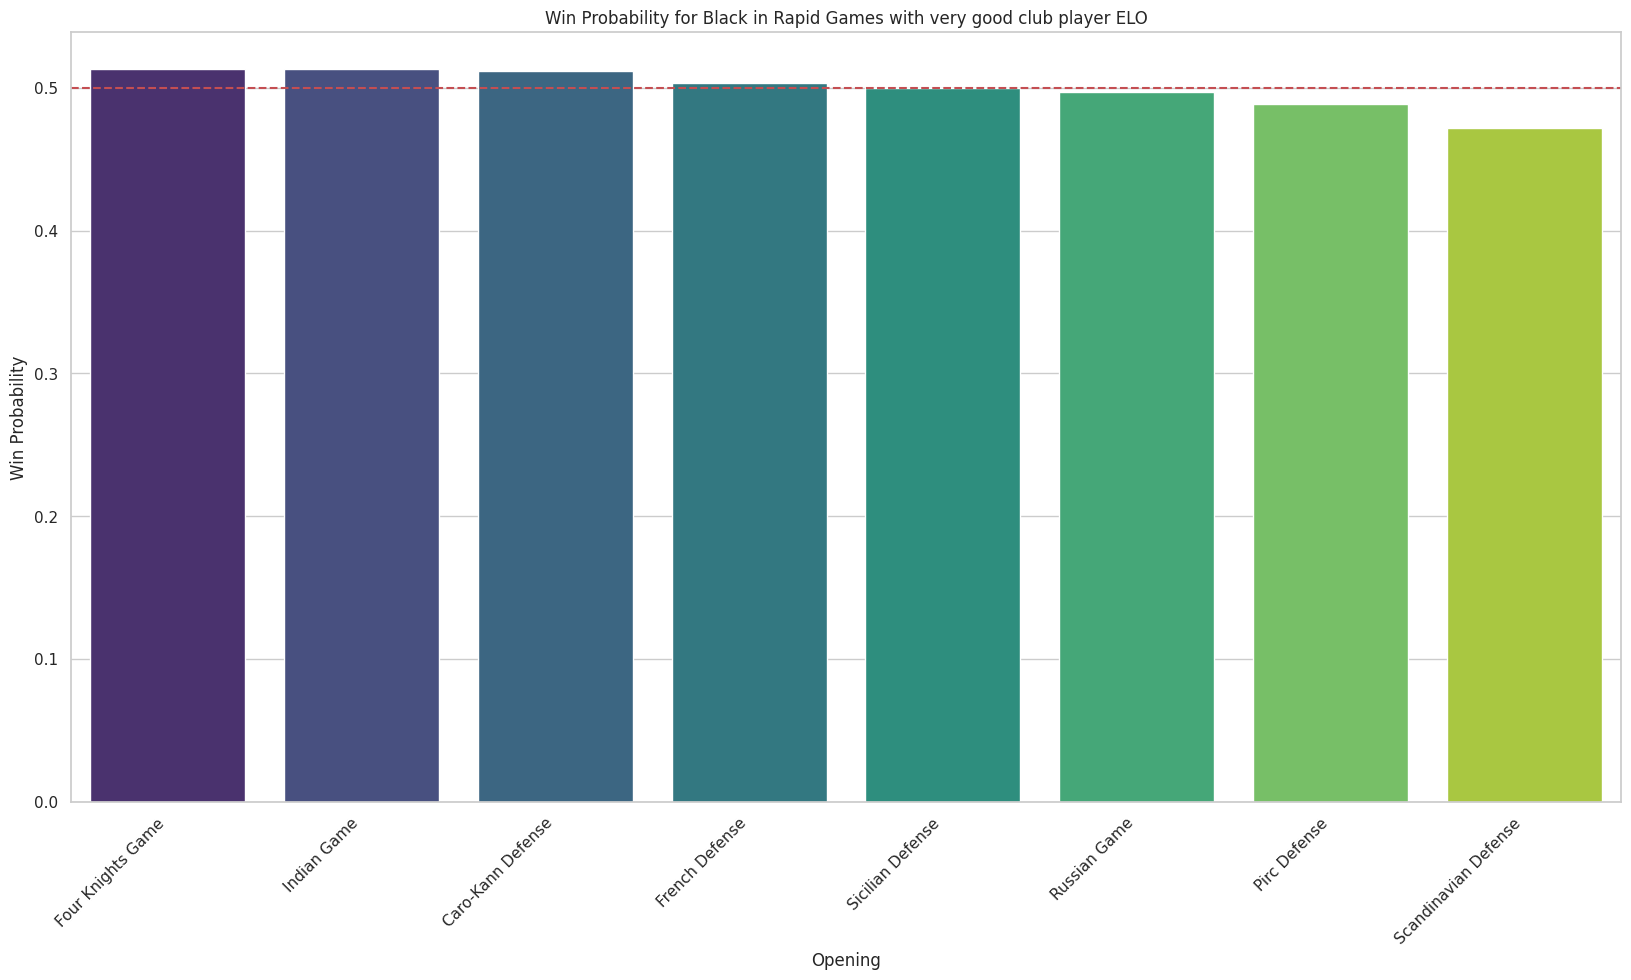

/tmp/ipykernel_81712/837899167.py:30: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='black_win_prob', data=filtered_df, palette="viridis")


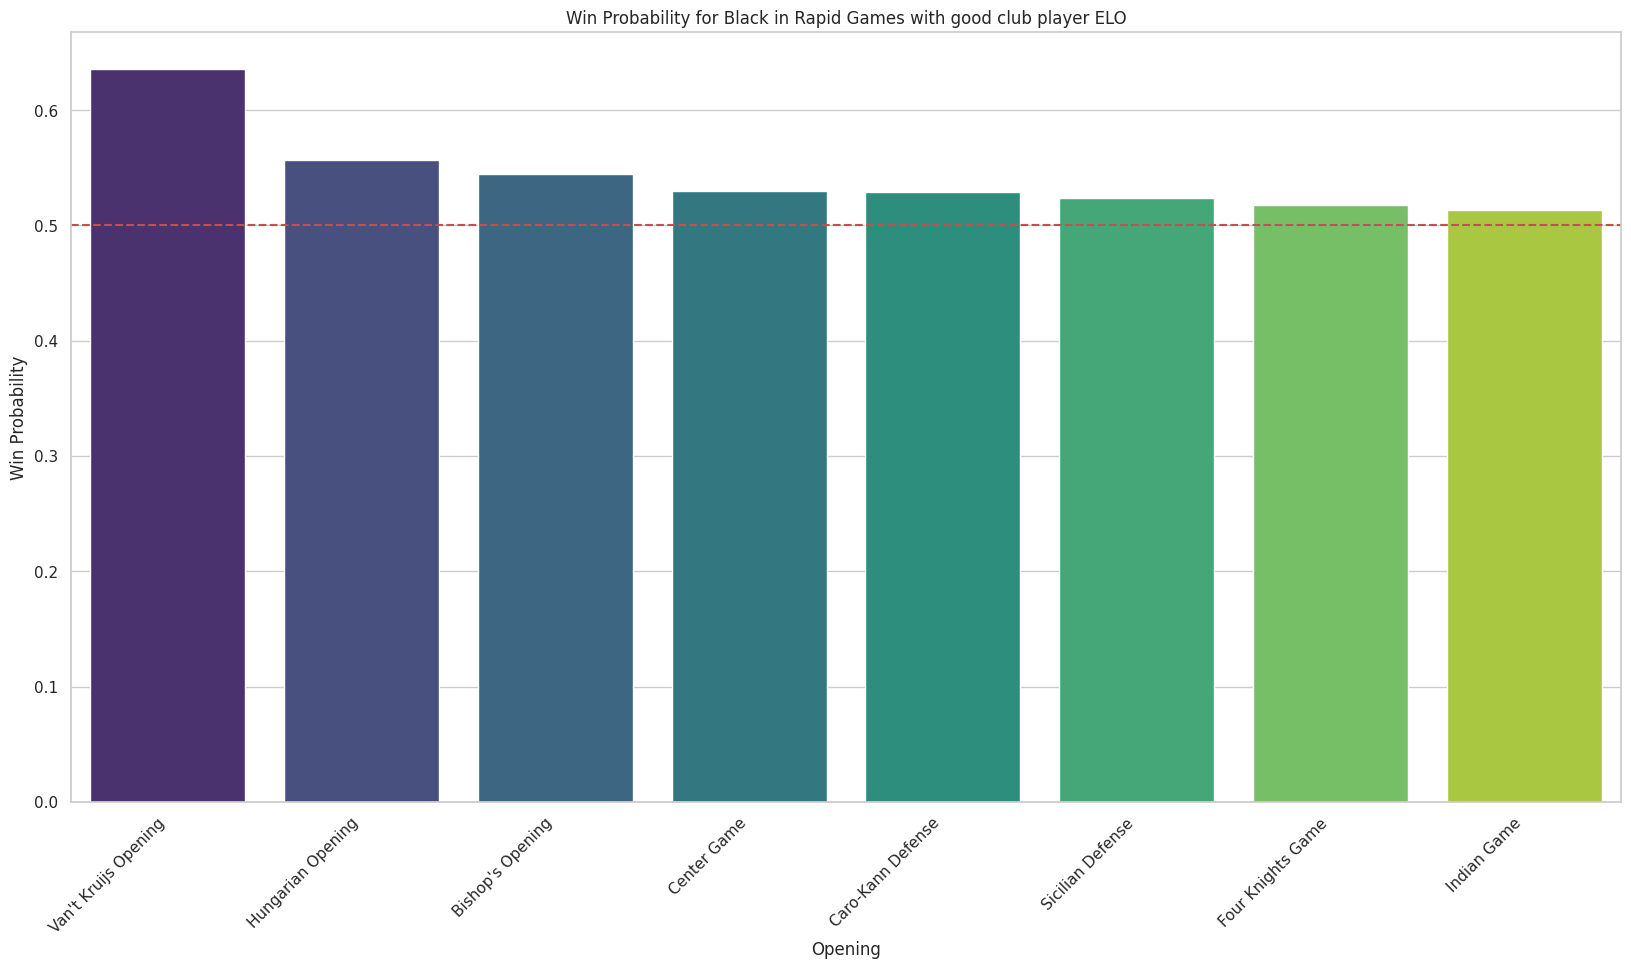

/tmp/ipykernel_81712/837899167.py:30: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='black_win_prob', data=filtered_df, palette="viridis")


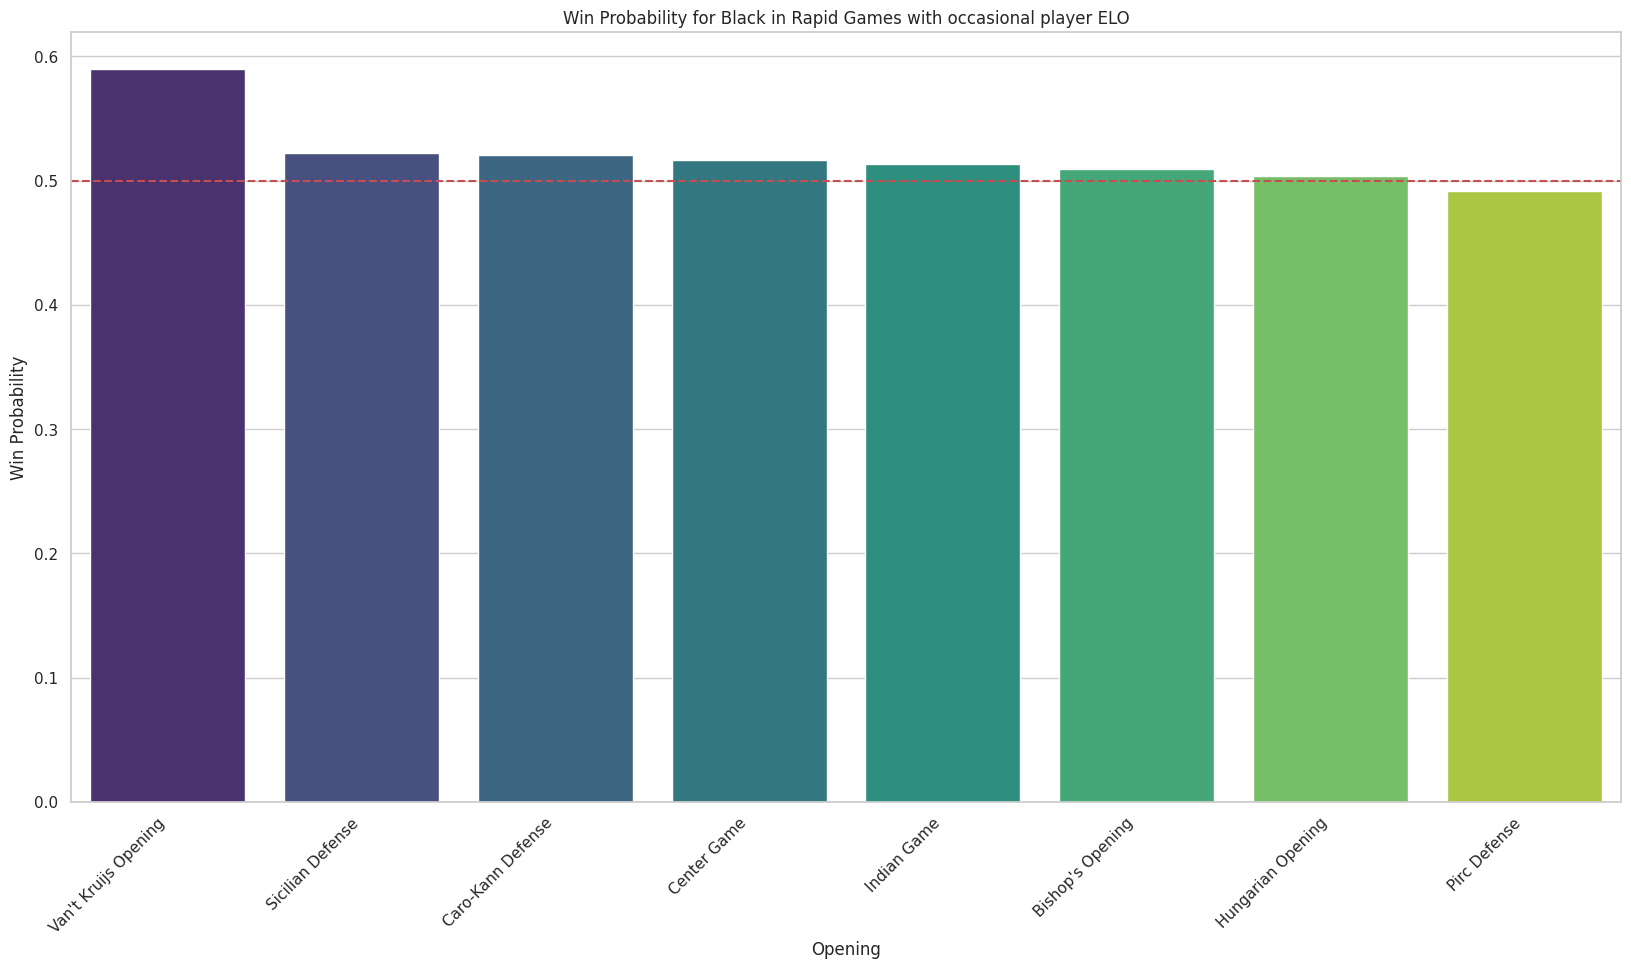

/tmp/ipykernel_81712/837899167.py:30: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opening_without_var', y='black_win_prob', data=filtered_df, palette="viridis")


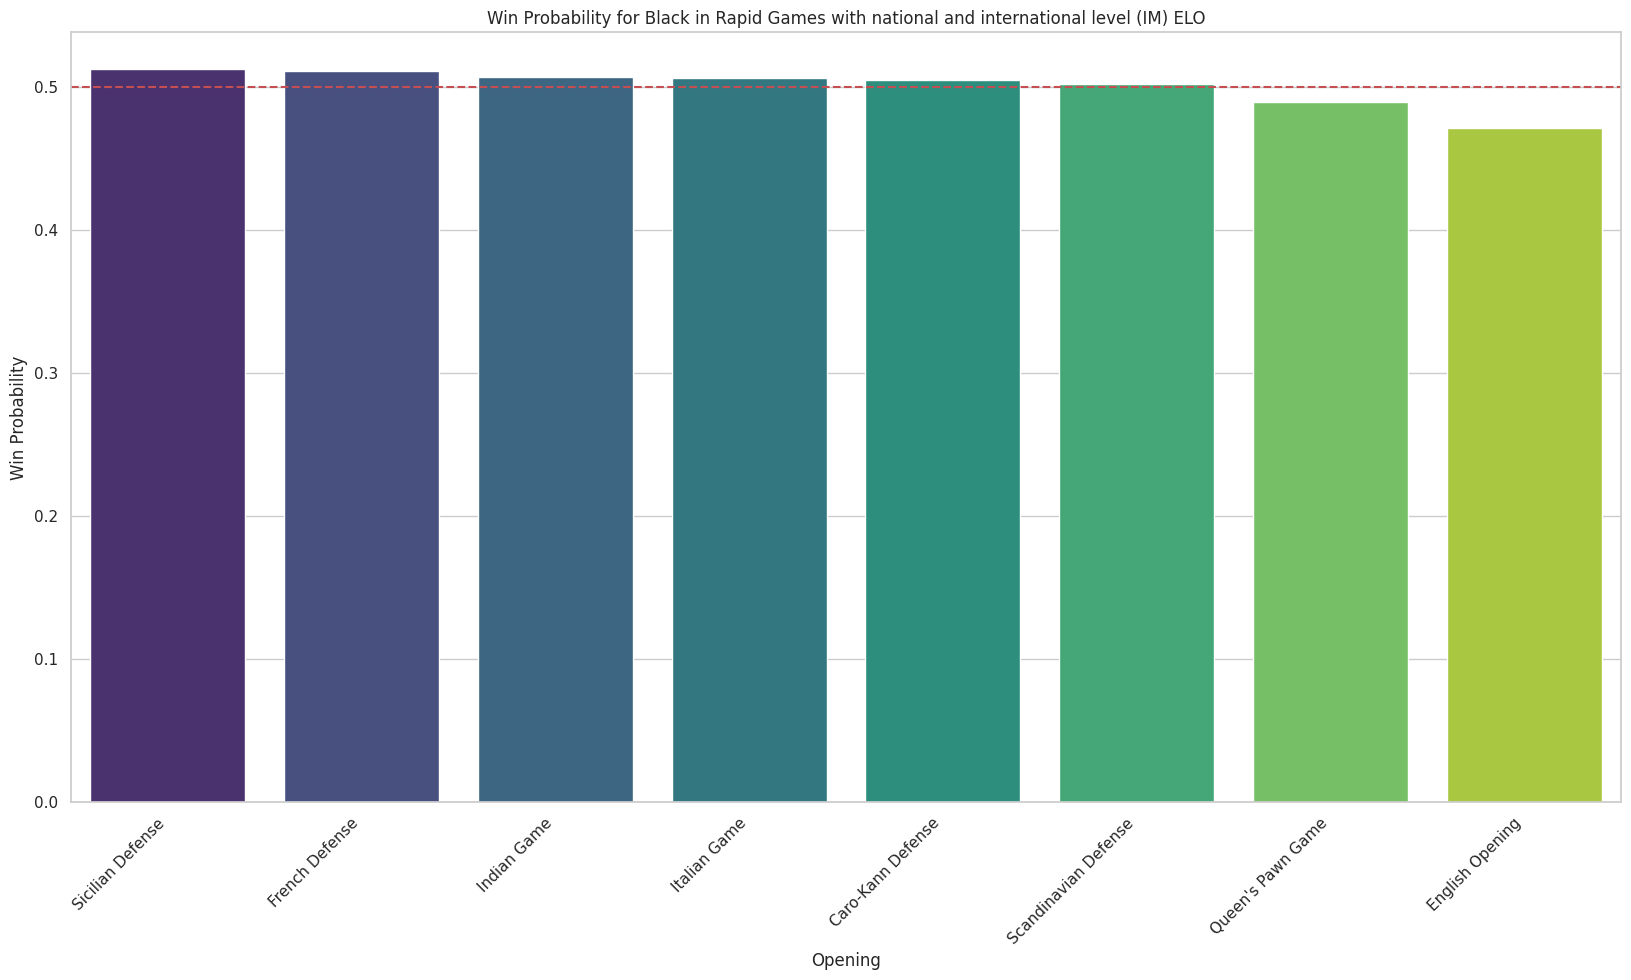

In [90]:
choice = input("Enter the game type (1 for Blitz, 2 for Rapid, 3 for Bullet): ")

if choice == "1":
    game_type = "Blitz"
elif choice == "2":
    game_type = "Rapid"
elif choice == "3":
    game_type = "Bullet"
else:
    print("Invalid choice")
    exit()
    
elo_categories = merged_df.select("Black_elo_category").distinct().rdd.flatMap(lambda x: x).collect()

for elo_category in elo_categories:
    # filter on the game type 
    filtered_df = merged_df.filter(merged_df["Game_type"] == game_type) 
    # filter on the elo category
    filtered_df = filtered_df.filter(filtered_df["Black_elo_category"] == elo_category)
    # convert to Pandas DataFrame
    filtered_df = filtered_df.toPandas()
    # if there are more than 8 openings, only keep the top 8
    if filtered_df.shape[0] > 8:
        filtered_df = filtered_df.head(8)
    if filtered_df.shape[0] == 0:
        print("There are no {} games with {} ELO with more than {}".format(game_type, elo_category, threshold))
        continue
    # plot the win probability for each opening
    plt.figure(figsize=(20, 10))
    sns.barplot(x='Opening_without_var', y='black_win_prob', data=filtered_df, palette="viridis")
    # add a horizontal hachuré line at 50% win rate
    plt.axhline(y=0.5, color='r', linestyle='--')
    # set the title
    plt.title("Win Probability for Black in {} Games with {} ELO".format(game_type, elo_category))
    # set the labels
    plt.xlabel("Opening")
    plt.ylabel("Win Probability")
    # rotate the x-axis labels
    plt.xticks(rotation=45, ha="right")
    # show the plot
    plt.show()

considering only the openings that are played more than 2000 times we have ->
For Black players the highest win rate openings by elo category in blitz games are : 
- GMI : Sicilian Defense
- MI : Bird's Opening, Russian Game, italian Game
- Very good club player : Bishop's Opening, King's Pawn Game, Bird's Opening
- Good club player : Van't Kruijs Opening, Hungarian Opening, Polish Opening
- occasional player : Van't Kruijs Opening, Hungarian Opening, Indian Game

for Rapid games we have :
- GMI : not enough data for reliable results
- MI : Sicilian Defense, French Defense, Indian Game
- Very good club player : Four Knights Game, Indian Game, Caro-Kann Defense
- Good club player : Van't Kruijs Opening, Hungarian Opening, Bishop's Opening
- occasional player : Van't Kruijs Opening, Siciian Defense, Caro-Kann Defense

for Bullet games we have :
- GMI : not enough data for reliable results
- MI : 
- Very good club player : Van't Kruijs Opening, Nimzo-larsen Attack, Alekhine Defense
- Good club player : Mieses Opening, Van't Kruijs Opening, Nimzo-larsen Attack
- occasional player : Nimzo-larsen Attack, Indian Game, Van't Kruijs Opening

### General Conclusion

In Blitz chess games with openings played over 2000 times, Black players demonstrate distinct strategic preferences. Grandmasters favor the dynamic Sicilian Defense, while International Masters show versatility with Bird's, Russian, and Italian Games. Very Good Club Players lean towards flexible openings like Bishop's and King's Pawn. Good Club Players exhibit a mix of Van't Kruijs, Hungarian, and Polish Openings. Occasional Players opt for simpler choices like Van't Kruijs and Hungarian.

## Q3 Predict the game outcome based on game's features

PREDICTING THE GAME OUTCOME BASED ONT HE AVAILABLE INFORMATION

the model use as features for the predection of 3 classes ( white win ,black win, draw) the following variables:

Total moves
ECO 
White ELO
Black ELO 
White blunders
Black blunders
White mistakes
Black mistakes
White inaccuracies
Black inaccuracies
Game flips
Starting time
Increment

In [91]:
prediction_features = [
    "Total_moves", "ECO","starting_time", "increment",
    "WhiteElo", "White_blunders", "White_mistakes", "White_inaccuracies",
    "BlackElo", "Black_blunders", "Black_mistakes", "Black_inaccuracies",
    "Game_flips"
]

df_prediction = df.select(*prediction_features, "Result")

# drop rows where Result is *
df_prediction = df_prediction.filter(df.Result != "*")

# drop rows where there is a null value

df_prediction = df_prediction.dropna()

In [92]:
from pyspark.ml.feature import StringIndexer

## we use StringIndexer to convert the ECO column to a numeric value for the model

# indexing the 'ECO' column
indexer = StringIndexer(inputCol="ECO", outputCol="ECO_index")
df_selected = indexer.fit(df_prediction).transform(df_prediction)

# dropping the 'ECO' column
df_selected = df_selected.drop("ECO")
prediction_features.remove("ECO")
prediction_features.append("ECO_index")

In [93]:
# set to true for computation time
downsampling = True
if downsampling :
    # take 10% of the data
    df_selected = df_selected.sample(False, 0.1, seed=42)

# splitting the data into training and testing sets
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)

df_selected.show(10)

+-----------+-------------+---------+--------+--------------+--------------+------------------+--------+--------------+--------------+------------------+----------+------+---------+
|Total_moves|starting_time|increment|WhiteElo|White_blunders|White_mistakes|White_inaccuracies|BlackElo|Black_blunders|Black_mistakes|Black_inaccuracies|Game_flips|Result|ECO_index|
+-----------+-------------+---------+--------+--------------+--------------+------------------+--------+--------------+--------------+------------------+----------+------+---------+
|         28|          600|        5|    1559|             0|             3|                 2|    1500|             0|             1|                 1|         3|   0-1|    207.0|
|         68|           60|        0|    1871|             6|             5|                 6|    1867|             4|             6|                 3|        10|   0-1|      4.0|
|         83|           60|        0|    1934|             0|             0|              

In [94]:
# converting to pandas for sklearn
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [96]:
# instantiate the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# instantiate the gradient boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

choice = input("Enter the model to use (1 for Random Forest, 2 for Gradient Boosting): ")
if choice == "1":
    classifier = rf_classifier
elif choice == "2":
    classifier = gb_classifier
else:
    print("Invalid choice")
    exit()
    

In [97]:
# fit the model rakes about 10 minutes
classifier.fit(train_data_pd[prediction_features], train_data_pd["Result"])

RandomForestClassifier(random_state=42)

In [98]:
# making predictions
predictions = classifier.predict(test_data_pd[prediction_features])

In [99]:
# evaluating the model
report = classification_report(test_data_pd["Result"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
print(report)

              precision    recall  f1-score   support

         1-0       0.85      0.87      0.86     30124
     1/2-1/2       0.63      0.12      0.20      1860
         0-1       0.84      0.86      0.85     28354

    accuracy                           0.84     60338
   macro avg       0.77      0.62      0.64     60338
weighted avg       0.84      0.84      0.83     60338



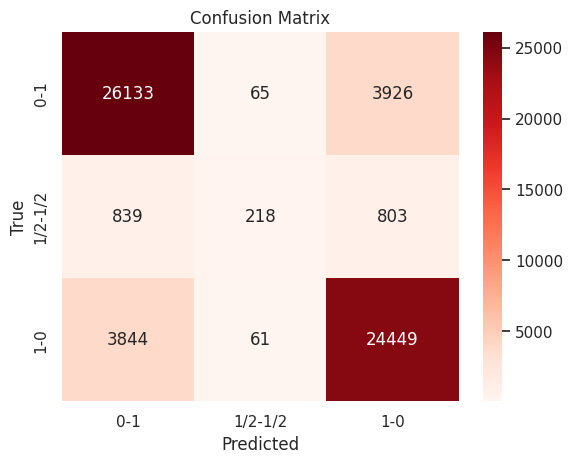

In [100]:
conf_matrix = confusion_matrix(test_data_pd["Result"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
# plotting the confusion matrix
plt.figure()
sns.heatmap(conf_matrix,annot=True,fmt="g",
    cmap="Reds",
    xticklabels=["0-1", "1/2-1/2", "1-0"],
    yticklabels=["0-1", "1/2-1/2", "1-0"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_81712/3801597461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=features_df, palette="rocket", orient="h")


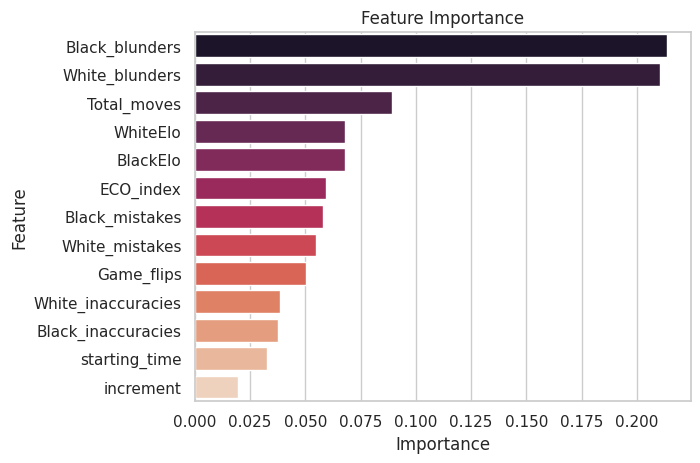

In [101]:
# feature importance
feature_importance = classifier.feature_importances_
features_df = pd.DataFrame(
    {"Feature": prediction_features, "Importance": feature_importance}
)
features_df = features_df.sort_values(by="Importance", ascending=False)

plt.figure()
sns.barplot(x="Importance", y="Feature", data=features_df, palette="rocket", orient="h")
plt.title("Feature Importance")
plt.show()

the number of blunders comes first as a major feature as expected to predict the game outcome, followed by the total number of moves, the elo of the players and the number of number of mistakes.

the two classification algorithms used give similar results, the accuracy prediction is around 0.84 for white win and 0.83 for black win and 0.61 for draw 
with a recall of 0.86 for white win and 0.85 for black win and a bad recall of 0.10 for draw.
This is due to the fact that the dataset is unbalanced and the selected features are not enough to predict the draw outcome.

# Q4 OPEN QUESTIONS : 

## Q4.1 Predicting Game Outcome with Fine-Grained Move Analysis

In this advanced analysis, we aim to predict game outcomes by considering fine-grained move data, such as blunders, mistakes, inaccuracies, and long moves in time scramble, for both Black and White players.

In [102]:
prediction_fine_grained_features = ["ECO", "WhiteElo", "BlackElo", "Total_moves", "Game_flips","Game_flips_ts",
                                     "Black_ts_moves", "White_ts_moves",
                                    "Black_ts_blunders", "White_ts_blunders", "Black_ts_mistakes", "White_ts_mistake",
                                    "Black_long_moves", "White_long_moves", "Black_bad_long_moves", "White_bad_long_moves",
                                    "starting_time","increment"
]

df_fg_prediction = df.select(*prediction_fine_grained_features, "Result")

# drop rows where Result is *
df_fg_prediction = df_fg_prediction.filter(df_fg_prediction.Result != "*")

# drop rows where there is a null value
df_fg_prediction = df_fg_prediction.dropna()    
                                

In [103]:
## we use StringIndexer to convert the ECO column to a numeric value for the model

# indexing the 'ECO' column
indexer = StringIndexer(inputCol="ECO", outputCol="ECO_index")
df_selected = indexer.fit(df_fg_prediction).transform(df_fg_prediction)

# dropping the 'ECO' column
df_selected = df_selected.drop("ECO")
prediction_fine_grained_features.remove("ECO")
prediction_fine_grained_features.append("ECO_index")

In [104]:
# set to true for computation time
downsampling = True
if downsampling :
    # take 10% of the data
    df_selected = df_selected.sample(False, 0.1, seed=42)

# splitting the data into training and testing sets
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)

df_selected.show(10)

+--------+--------+-----------+----------+-------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+-------------+---------+------+---------+
|WhiteElo|BlackElo|Total_moves|Game_flips|Game_flips_ts|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|starting_time|increment|Result|ECO_index|
+--------+--------+-----------+----------+-------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+-------------+---------+------+---------+
|    1559|    1500|         28|         3|            0|             0|             0|                0|                0|                0|               0|               3| 

In [105]:
# converting to pandas for sklearn
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# instantiate the gradient boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

choice = input("Enter the model to use (1 for Random Forest, 2 for Gradient Boosting): ")
if choice == "1":
    classifier = rf_classifier
elif choice == "2":
    classifier = gb_classifier
else:
    print("Invalid choice")
    exit()

In [107]:
# fit the model rakes about 10 minutes withou downsampling
classifier.fit(train_data_pd[prediction_fine_grained_features], train_data_pd["Result"])

RandomForestClassifier(random_state=42)

In [108]:
# making predictions
predictions = classifier.predict(test_data_pd[prediction_fine_grained_features])

In [109]:
from sklearn.metrics import confusion_matrix, classification_report

# evaluating the model
report = classification_report(test_data_pd["Result"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
print(report)

              precision    recall  f1-score   support

         1-0       0.72      0.75      0.74     30165
     1/2-1/2       0.39      0.04      0.07      1874
         0-1       0.71      0.72      0.71     28299

    accuracy                           0.71     60338
   macro avg       0.61      0.50      0.51     60338
weighted avg       0.70      0.71      0.70     60338



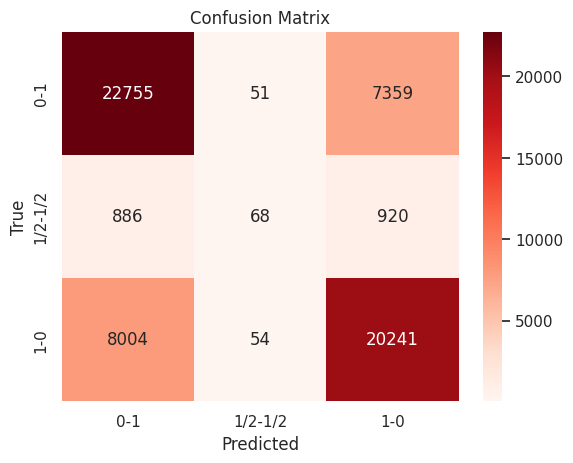

In [110]:
# plotting the confusion matrix
conf_matrix = confusion_matrix(test_data_pd["Result"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
plt.figure()
sns.heatmap(conf_matrix,annot=True,fmt="g",
    cmap="Reds",
    xticklabels=["0-1", "1/2-1/2", "1-0"],
    yticklabels=["0-1", "1/2-1/2", "1-0"],
)
# set the labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_81712/3298973988.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=features_df, palette="rocket", orient="h")


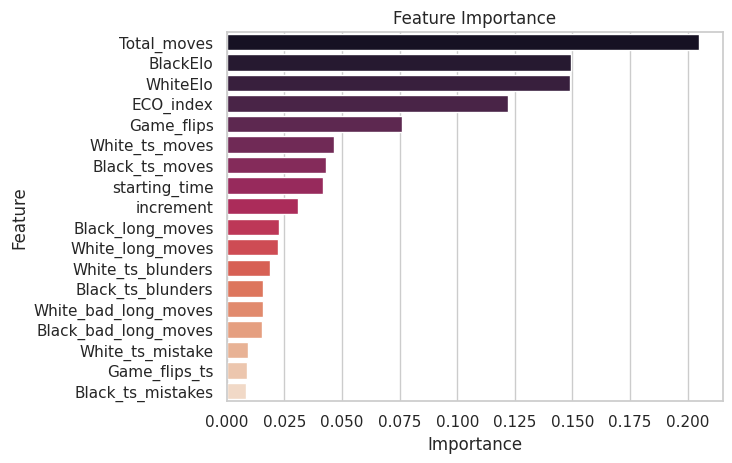

In [111]:
# feature importance

feature_importance = classifier.feature_importances_
features_df = pd.DataFrame(
    {"Feature": prediction_fine_grained_features, "Importance": feature_importance}
)
features_df = features_df.sort_values(by="Importance", ascending=False)

plt.figure()
sns.barplot(x="Importance", y="Feature", data=features_df, palette="rocket", orient="h")
plt.title("Feature Importance")
plt.show()

the performance of model on draw prediction is very bad, this is due to the fact that the dataset is unbalanced and the selected features are not enough to predict the draw outcome.

The fine grained information especially the number of inferior moves does not help to predict the game outcome as good as the number of blunders, mistakes and inaccuracies. while the only feature that helps to predict are the black and white time scramble moves and blunders but the main feature is the number of total moves and the elo of each player.

## Q4.2 IS there a correlation between the number of blunders and Game flips?

In [112]:
from pyspark.sql.functions import col, corr

# Select relevant columns for analysis
correlation_data = df.select("Black_blunders", "White_blunders", "Game_flips")

# add columns for total blunders 
correlation_data = correlation_data.withColumn("Total_blunders", col("Black_blunders") + col("White_blunders"))

# compute the correlation between the Total_blunders and Game_flips
correlation_result = correlation_data.select(corr("Total_blunders", "Game_flips")).collect()

# Print the results
print("The correlation between the total number of blunders and the number of game flips is {:.2f}".format(correlation_result[0][0]))

The correlation between the total number of blunders and the number of game flips is 0.56


The correlation coefficient of 0.58 suggests a moderate positive correlation between the total number of blunders and the occurrence of game flips in chess games. This indicates that as the number of blunders increases, there is a tendency for a higher frequency of game flips, reflecting shifts in the positional advantage between players.

## Q4.3 IS there a correlation between the number of blunders and elo rating?

In [113]:
from pyspark.sql.functions import col

# Select relevant columns for analysis
elo_blunders_data = df.filter(df["Game_type"] == "Blitz").select("BlackElo", "WhiteElo", "Black_blunders", "White_blunders")

# Calculate the ELO difference between players
elo_blunders_data = elo_blunders_data.withColumn("ELO_difference", col("WhiteElo") - col("BlackElo"))

# make sure the ELO difference is positive
elo_blunders_data = elo_blunders_data.withColumn("ELO_difference", F.abs(col("ELO_difference")))

# Calculate the rate of blunders for both Black and White players
elo_blunders_data = elo_blunders_data.withColumn("blunder_rate", (col("Black_blunders") + col("White_blunders")) / 2)

# correlation between ELO difference and blunder rate
correlation_result = elo_blunders_data.select(
    corr("ELO_difference", "blunder_rate").alias("correlation")
)

# print the correlation
correlation_result.show()



+-------------------+
|        correlation|
+-------------------+
|-0.0477226470145484|
+-------------------+



The correlation coefficient of approximately -0.0297 indicates a very weak negative correlation between the number of blunders and ELO ratings in chess games.

The low correlation implies that ELO rating alone may not be a strong predictor of the number of blunders. Other factors or a combination of features might contribute more significantly to the occurrence of blunders in chess games.

While there is a slight overall trend, individual player behavior can vary significantly. Players with higher ELO ratings may still make blunders, thus more game flips.